# ML — SVR Modeling (Clean Data Template)


Purpose
-------
Prepare cleaned, model-ready car-pricing data and evaluate Support Vector Regression baselines using the project's preprocessing utilities and feature-selection procedures.



Datasets used
--------------
- `Data/train.csv` — labeled training data
- `Data/test.csv` — unlabeled test data (used for final submission workflows)
- External vehicle models (downloaded from Kaggle: `vehicle models.json`)



Expected outputs
----------------
- A fitted `DataPreprocessor` instance for reproducible transforms
- A concise selected feature list (from feature-selection steps)
- Trained baseline models (SVR and optionally others) and saved model artifacts (pickle/joblib)
- Evaluation metrics: RMSE, MAE, R² (table)
- Diagnostic figures: predicted vs true, residuals, error distribution
- Optional: a submission CSV ready for Kaggle

## Table of Contents
- [Environment & Imports](#Environment--Imports)  
- [Data Loading](#Data-Loading)
- [Preprocessing Pipeline](#Preprocessing-Pipeline)  
- [Feature Engineering & Selection](#Feature-Engineering-&-Selection)
- [Train / Validation / Test Splits](#Train-/-Validation-/-Test-splits)
- [Model Definition & Training](#Model-Definition-&-Training)
- [Hyperparameter Search](#Hyperparameter-Search)
- [Model Evaluation & Diagnostics](#Model-Evaluation-&-Diagnostics)
- [Final Predictions & Submission](#Final-Predictions-&-Submission)
- [Conclusions & Next Steps](#Conclusions-&-Next-Steps)
- [Appendix & Utilities](#Appendix-&-Utilities)

## Data Loading
Load the primary datasets into pandas DataFrames and run a very short inspection (shape, dtypes, top rows, and missing-value counts). Keep heavy EDA in a separate notebook to keep this file concise.

In [1]:
import pandas as pd# type: ignore
import numpy as np# type: ignore
import os
import json
import kagglehub# type: ignore
import warnings
import traceback
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt# type: ignore
import seaborn as sns # type: ignore
# Load preprocessing classes
os.chdir('../')  # Change to project root directory
# Preprocessing and utility imports
from utils.preprocessing.CarDatabase import ProductionCarMatcher, create_optimized_database
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
from wordcloud import WordCloud  # Import WordCloud module
import matplotlib.pyplot as plt


print("SIMPLE ML TEMPLATE - FAST CLEAN DATA")
print("=" * 45)

# CONFIGURATION - Change these as needed
CONFIG = {

    'random_state': 42,
    'target_column': 'price',
    
    # Preprocessing options
    'outlier_removal': True,          # Remove outliers?
    'feature_scaling': True,          # Scale features?
    'encoding_method': 'onehot',        # 'mean', 'onehot'
    
    # Feature transformations
    'log_transform_mileage': True,    # Log transform mileage?
    'convert_year_to_age': True,      # Convert year to car age?
    'normalize_paint': True,          # Normalize paint quality to 0-1?
    'normalize_engine': True,         # Convert engine size units?
    
    # Toggle a short search for fast iteration (set to False for full grid)
    'SHORT_SEARCH': True,
}
if CONFIG['SHORT_SEARCH']:
    CONFIG['n_splits'] = 2
    CONFIG['n_repeats'] = 2
    print("WARNING: SHORT_SEARCH is enabled. Using a subset of data and parameter combinations for quick testing, not for final evaluation.")
print(f"Configuration: {CONFIG}")

/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SIMPLE ML TEMPLATE - FAST CLEAN DATA
Configuration: {'random_state': 42, 'target_column': 'price', 'outlier_removal': True, 'feature_scaling': True, 'encoding_method': 'onehot', 'log_transform_mileage': True, 'convert_year_to_age': True, 'normalize_paint': True, 'normalize_engine': True, 'SHORT_SEARCH': True, 'n_splits': 2, 'n_repeats': 2}


## Data Loading
Loads the raw CSV files into pandas DataFrames and performs a quick sanity check (shape, dtypes, head, missing values). Run this cell before the preprocessing pipeline.

In [2]:
# Load datasets and quick sanity checks
raw_train_data = pd.read_csv('Data/train.csv')
test_data = pd.read_csv('Data/test.csv')
if CONFIG['SHORT_SEARCH']:
    raw_train_data = raw_train_data.sample(n=500, random_state=CONFIG['random_state']).reset_index(drop=True)
    test_data = test_data.sample(n=200, random_state=CONFIG['random_state']).reset_index(drop=True)

print(f"Loaded: train -> {raw_train_data.shape}, test -> {test_data.shape}")

print('\n--- Train dtypes ---')
print(raw_train_data.dtypes)

print('\n--- Train head (5 rows) ---')
display(raw_train_data.head(5))

print('\n--- Top 10 missing counts (train) ---')
print(raw_train_data.isnull().sum().sort_values(ascending=False).head(10))

missing_pct = (raw_train_data.isnull().mean() * 100).sort_values(ascending=False).head(10)
print('\n--- Top 10 missing percent (train) ---')
print(missing_pct.round(2))



Loaded: train -> (500, 14), test -> (200, 13)

--- Train dtypes ---
carID               int64
Brand              object
model              object
year              float64
price               int64
transmission       object
mileage           float64
fuelType           object
tax               float64
mpg               float64
engineSize        float64
paintQuality%     float64
previousOwners    float64
hasDamage         float64
dtype: object

--- Train head (5 rows) ---


,carID,Brand,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage
0,44722,Mercedes,GLC Class,2018.0,28995,Automatic,9500.0,Diesel,150.0,56.5,2.1,77.0,0.0,NaN
1,35963,Mercedes,C Class,2017.0,13800,Automatic,50369.0,Diesel,20.0,65.7,2.1,80.0,4.0,0.0
2,50618,Skoda,Citigo,2017.0,7000,manual,7489.0,Petrol,150.0,64.2,1.0,84.0,4.0,0.0
3,69344,VW,Touareg,2019.0,45492,Automatic,7000.0,Diesel,145.0,34.0,3.0,62.0,0.0,0.0
4,26815,Ford,Focus,2019.0,14698,Manual,10812.0,DIESEL,NaN,NaN,1.5,99.0,2.0,0.0



--- Top 10 missing counts (train) ---
tax               49
mpg               45
transmission      15
model             14
hasDamage         13
mileage           12
paintQuality%     12
previousOwners    11
fuelType          10
engineSize         9
dtype: int64

--- Top 10 missing percent (train) ---
tax               9.8
mpg               9.0
transmission      3.0
model             2.8
hasDamage         2.6
mileage           2.4
paintQuality%     2.4
previousOwners    2.2
fuelType          2.0
engineSize        1.8
dtype: float64


## Preprocessing Pipeline Explanation
This section explains the high-level purpose of preprocessing and shows a minimal example of using the project's `DataPreprocessor` to produce model-ready features (X) and target (y).

Why & what
-----------
- Why: Ensure consistent handling of missing values, outliers, encoding and scaling so models receive reproducible, comparable inputs.
- What: Use `utils.preprocessing.DataPreprocessor` to encapsulate feature pipelines (imputation, transforms, encoding, scaling). Keep detailed pipeline code in `utils/` and call it from the notebook.

Contract
--------
- Inputs: Raw pandas DataFrame (must contain the target column defined in `CONFIG['target_column']`).
- Outputs: X (DataFrame of processed features), y (Series of target values).
- Errors: Missing target or required columns will raise a clear exception. Keep datasets sampled during development to speed iteration.

```python
# Minimal example usage of DataPreprocessor (high-level)
from utils.preprocessing.Preprocessor_divided import DataPreprocessor
from utils.preprocessing.Cardinal_Preprocessor import CardinalMapper
import joblib

# Initialize preprocessor (detailed pipelines live in `utils/` and/or are configured below using `feature_configs`)
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])

# Example: add a couple of feature pipelines in-place (keep full config in `feature_configs` later)
preprocessor.add_feature_pipeline('mileage', missing_strategy='median', transform_func=(log_transform if CONFIG.get('log_transform_mileage') else None), scaling_method=('standard' if CONFIG.get('feature_scaling') else None))
preprocessor.add_feature_pipeline('year', missing_strategy='mean', transform_func=(year_to_age if CONFIG.get('convert_year_to_age') else None), scaling_method=('minmax' if CONFIG.get('feature_scaling') else None))

# Fit-transform on a small sample for quick iteration (swap to full `train_data` when ready)
sample_train = train_data.sample(frac=0.2, random_state=CONFIG['random_state'])
X_sample, y_sample = preprocessor.fit_transform(sample_train)

print(f"Preprocessor fit on sample -> X: {X_sample.shape}, y: {y_sample.shape}")

# Persist fitted preprocessor for reproducibility (optional)
joblib.dump(preprocessor, 'artifacts/fitted_preprocessor_sample.joblib')
```


## Preprocessing Pipeline
Why & What
- Why: Convert raw, messy car data into a reproducible, model-ready feature matrix (X) and target vector (y).
- What: We reuse the project's preprocessing utilities in `utils/preprocessing/` (e.g., `DataPreprocessor`, `CardinalMapper`) so the notebook stays high-level.



Contract (short)
- Inputs: `train_data` DataFrame with expected raw columns, `CONFIG` and `feature_configs` defined above.
- Outputs: `X` (DataFrame), `y` (Series), and a fitted `preprocessor` object.
- Error modes: missing target column will raise; unexpected/missing features will be skipped with a warning.

In [3]:
path = kagglehub.dataset_download("bourzamraid/global-car-make-and-model-list")
with open(os.path.join(path, 'vehicle models.json'), 'r') as f:
    kaggle_data = json.load(f)
        
# Create matcher and clean brands
optimized_db = create_optimized_database(kaggle_data, max_model_words=3)
matcher = ProductionCarMatcher(optimized_db)
        
_, train_data_results  =  matcher.clean_dataframe(raw_train_data,
                                        'Brand',
                                        'model')
_, test_data_results  =  matcher.clean_dataframe(test_data,
                                        'Brand',
                                        'model')
# concat the cleaned data with the target column
train_data = pd.concat([raw_train_data.loc[train_data_results.index], train_data_results[['clean_make', 'clean_model']]], axis=1)
test_data = pd.concat([test_data.loc[test_data_results.index], test_data_results[['clean_make', 'clean_model']]], axis=1)
# dorp Brand and model columns
train_data = train_data.drop(columns=['Brand', 'model'])
test_data = test_data.drop(columns=['Brand', 'model'])

fueltype_dict = {
    'Petrol': (['petrol', 'petro', 'etrol', 'etro', 'petr', 'ptrol' ],
               [ 'diesel', 'hybrid', 'electric',  'other', 'electri' ]),
    'Diesel': (['diesel', 'diese', 'iesel', 'iese', 'dise' ],
               [ 'petrol', 'hybrid', 'electric',  'other' ]),
    'Hybrid': (['hybrid', 'hybri', 'ybrid', 'ybri', 'hyb' ],
               [ 'petrol', 'diesel', 'electric',  'other' ]),
    'Electric': (['electric', 'elect', 'electri', 'lectri', 'elec', 'ele'],
               [ 'petrol', 'diesel', 'hybrid',  'other' ]),
    'Other': (['other', 'othe', 'oth' ],
               [ 'petrol', 'diesel', 'hybrid',  'electric' ]) }

transmission_dict = {
    'Manual': ([ 'man', 'manual', 'm', 'stick', 'standard', 'mt' ],
               [ 'auto', 'semi', 'automatic', 'tiptronic', 'emi','mi','other' ]),
    'Semi-Auto': (['semi', 'semi-auto', 'tiptronic', 'emi','mi' ],
                    [ 'manual', 'stick', 'full manual', 'Other' ]),
    'Automatic': (['auto', 'automatic', 'a', 'at' ],
                  [ 'semi', 'manual', 'stick', 'tiptronic', 'emi','mi', 'other' ]) }


fuel_mapper = CardinalMapper(fueltype_dict)
transmission_mapper = CardinalMapper(transmission_dict)

print("Mapping fuelType and transmission columns...")
train_data['fuelType'] = fuel_mapper.fit_transform(train_data['fuelType'])
train_data['transmission'] = transmission_mapper.fit_transform(train_data['transmission'])
print(f"fuelType value counts:\n{train_data['fuelType'].value_counts()}")
test_data['fuelType'] = fuel_mapper.fit_transform(test_data['fuelType'])
test_data['transmission'] = transmission_mapper.fit_transform(test_data['transmission'])
print(f"transmission value counts:\n{train_data['transmission'].value_counts()}")


Analyzing word frequencies...
Created optimized database with 146 makes
Cleaning 500 records...


Processing records: 100%|██████████| 500/500 [00:01<00:00, 302.48it/s]


Cleaning 200 records...


Processing records: 100%|██████████| 200/200 [00:00<00:00, 245.76it/s]

Mapping fuelType and transmission columns...
fuelType value counts:
fuelType
Petrol    266
Diesel    209
Hybrid     15
Other      10
Name: count, dtype: int64
transmission value counts:
transmission
Manual       271
Automatic    113
Semi-Auto     99
Other         17
Name: count, dtype: int64


In [4]:
# Define transformations that can be applied to features
def log_transform(x:pd.Series)->pd.Series:
    return np.log1p(np.abs(x)+1)

def year_to_age(year_series:pd.Series)->pd.Series:
    return 2025 - np.abs(np.floor(year_series))

def normalize_paint(paint_series:pd.Series)->pd.Series:
    return np.clip(paint_series, 0, 100) / 100

def normalize_engine(engine_series:pd.Series)->pd.Series:
    result = engine_series.copy()
    small_engines = engine_series <= 10
    result[small_engines] = engine_series[small_engines] * 1000
    return result


In [5]:
from utils.preprocessing.Preprocessor_divided import DataPreprocessor

In [6]:
# Configure features
feature_configs = {
    'mileage': {
        'missing_strategy': 'median',
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'transform_func': log_transform if CONFIG['log_transform_mileage'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'year': {
        'missing_strategy': 'mean',
        'transform_func': year_to_age if CONFIG['convert_year_to_age'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'engineSize': {
        'missing_strategy': 'median',
        'transform_func': normalize_engine if CONFIG['normalize_engine'] else None,
        'scaling_method': 'robust' if CONFIG['feature_scaling'] else None
    },
    'tax': {
        'missing_strategy': 'median',
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'mpg': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.abs(x),
        'outlier_method': 'iqr' if CONFIG['outlier_removal'] else None,
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'paintQuality%': {
        'missing_strategy': 'median',
        'transform_func': normalize_paint if CONFIG['normalize_paint'] else None,
        'scaling_method': 'minmax' if CONFIG['feature_scaling'] else None
    },
    'previousOwners': {
        'missing_strategy': 'median',
        'transform_func': lambda x: np.log1p(np.abs(np.floor(x))),
        'scaling_method': 'standard' if CONFIG['feature_scaling'] else None
    },
    'hasDamage': {
        'missing_strategy': 1,
        'scaling_method': None
    },
    'clean_make': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean'  # use mean encoding for make in any case, regardless of CONFIG because of high cardinality
    },
    'clean_model': {
        'missing_strategy': 'mode',
        'encoding_method': 'mean', # use mean encoding for models in any case, regardless of CONFIG because of high cardinality
    },
    'transmission': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],

    },
    'fuelType': {
        'missing_strategy': 'mode',
        'encoding_method': CONFIG['encoding_method'],
    }
}

In [ ]:
# fit_transform training data and transform feature selection and validation data
preprocessor = DataPreprocessor(target_column=CONFIG['target_column'])


for feature, feature_config in feature_configs.items():
    if feature in train_data.columns:
        preprocessor.add_feature_pipeline(feature, **feature_config)  
        
#drop carID column
train_data = train_data.drop(columns=['carID'])
# we are already transformun the partitions becuse during k-fold CV we are going to fit_transform again and we don't want to lose the transformations for the final model validation
X_train, y_train = preprocessor.fit_transform(train_data)
X_test, _ = preprocessor.transform(test_data)


# Data is Clean — Start Modeling
---

**Instantiated `DataPreprocessor` Object**

The reason we don't clean the dataset and save it as a new CSV file is to keep track of the preprocessing steps and be able to reproduce them on new data (e.g., test set, future data, cross-validation folds, etc.). This approach avoids data leakage, as encoding and scaling should be fitted only on the training data and then applied to the validation/test data. A fitted preprocessor can be saved and loaded later for consistent transformations.


In [8]:
from utils.data_exploration.data_exploration import analyze_numerical_feature, suggest_transformations, analyze_categorical_feature, analyze_missing_data

In [9]:
# Dataset shape and basic info
print("=== DATASET OVERVIEW ===")
print(f"Training set shape: {train_data.shape}")
print(f"Test set shape: {test_data.shape}")
print(f"Total features: {len(train_data.columns)}")

# Feature types
numerical_features = train_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")

print("\n=== FEATURE TYPES ===")
print("Numerical:", numerical_features)
print("Categorical:", categorical_features)

# Display first few rows
print("\n=== SAMPLE DATA ===")
display(train_data.head())

=== DATASET OVERVIEW ===
Training set shape: (500, 13)
Test set shape: (200, 13)
Total features: 13
Numerical features: 9
Categorical features: 4

=== FEATURE TYPES ===
Numerical: ['year', 'price', 'mileage', 'tax', 'mpg', 'engineSize', 'paintQuality%', 'previousOwners', 'hasDamage']
Categorical: ['transmission', 'fuelType', 'clean_make', 'clean_model']

=== SAMPLE DATA ===


,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,paintQuality%,previousOwners,hasDamage,clean_make,clean_model
0,2018.0,28995,Automatic,9500.0,Diesel,150.0,56.5,2.1,77.0,0.0,NaN,mercedes-benz,glc class
1,2017.0,13800,Automatic,50369.0,Diesel,20.0,65.7,2.1,80.0,4.0,0.0,mercedes-benz,c class
2,2017.0,7000,Manual,7489.0,Petrol,150.0,64.2,1.0,84.0,4.0,0.0,skoda,citigo
3,2019.0,45492,Automatic,7000.0,Diesel,145.0,34.0,3.0,62.0,0.0,0.0,volkswagen,touareg
4,2019.0,14698,Manual,10812.0,Diesel,NaN,NaN,1.5,99.0,2.0,0.0,ford,focus


In [10]:
train_missing = analyze_missing_data(X_train, "Training Set")
test_missing = analyze_missing_data(X_test, "Test Set")

=== TRAINING SET MISSING DATA ANALYSIS ===
Total rows: 500
Rows with at least one NaN: 0 (0.00%)
No missing values found!
=== TEST SET MISSING DATA ANALYSIS ===
Total rows: 200
Rows with at least one NaN: 0 (0.00%)
No missing values found!


## Analize Numerical Features

--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: year ---
--------------------------------------------------

ANALYZING: YEAR
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: 0.0
Max: 0.9999999999999999
Mean: 0.264
Median: 0.273
Std: 0.103
Skewness: 2.329
Kurtosis: 12.130

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 3 (0.60%)
Outliers (IQR method): 8 (1.60%)


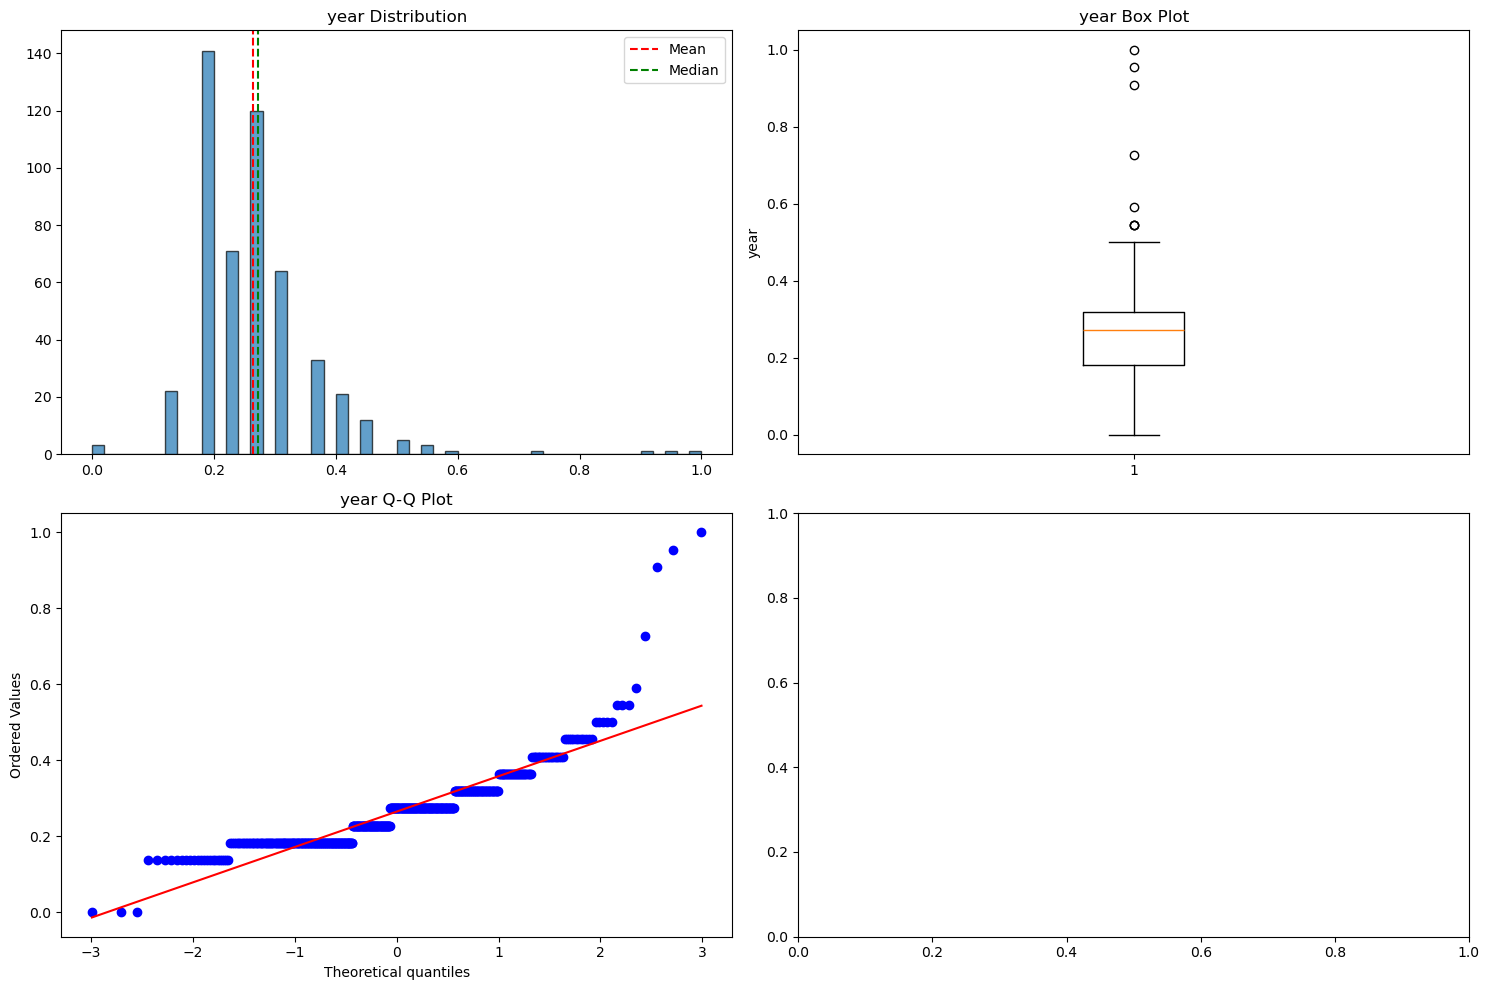


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Highly right-skewed - consider log transformation

=== TRANSFORMATION EXPERIMENTS FOR YEAR ===
log1p_abs: Skewness 2.329 → 1.525
log1p_shifted: Skewness 2.329 → 1.831
sqrt: Skewness 2.329 → 0.218


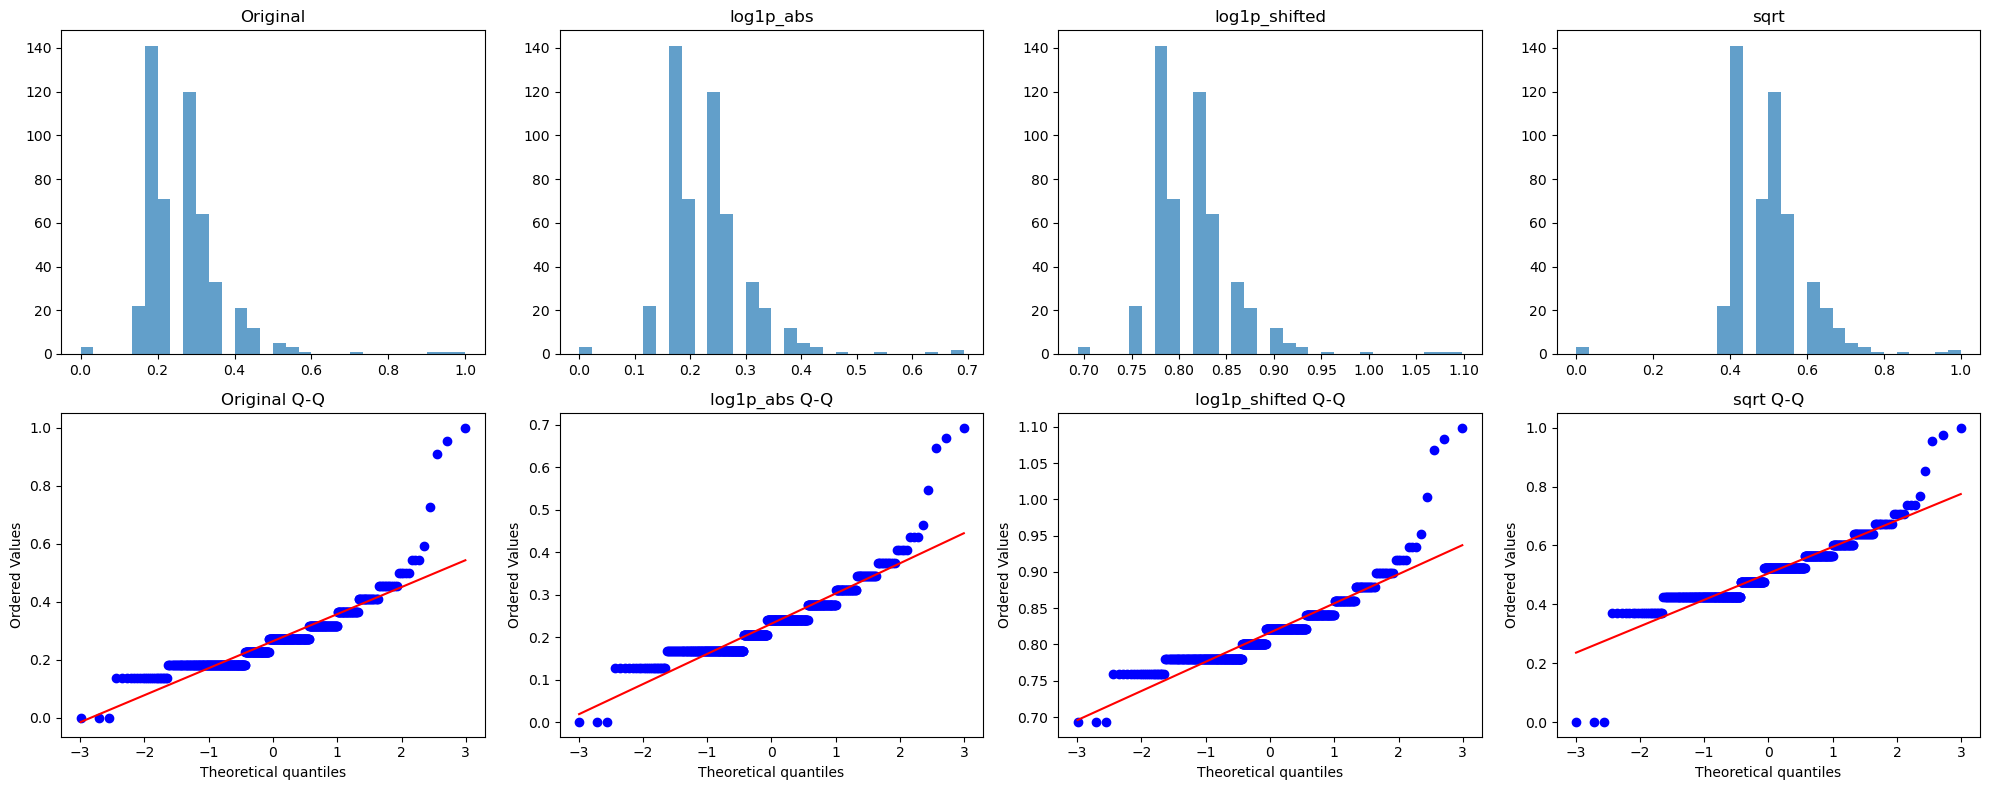







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: mileage ---
--------------------------------------------------

ANALYZING: MILEAGE
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: -4.528588859531618
Max: 1.102270135095186
Mean: 0.000
Median: 0.196
Std: 1.001
Skewness: -2.257
Kurtosis: 6.331

=== DATA QUALITY ASSESSMENT ===
Negative values: 189 (37.80%)
Zero values: 0 (0.00%)
Outliers (IQR method): 24 (4.80%)


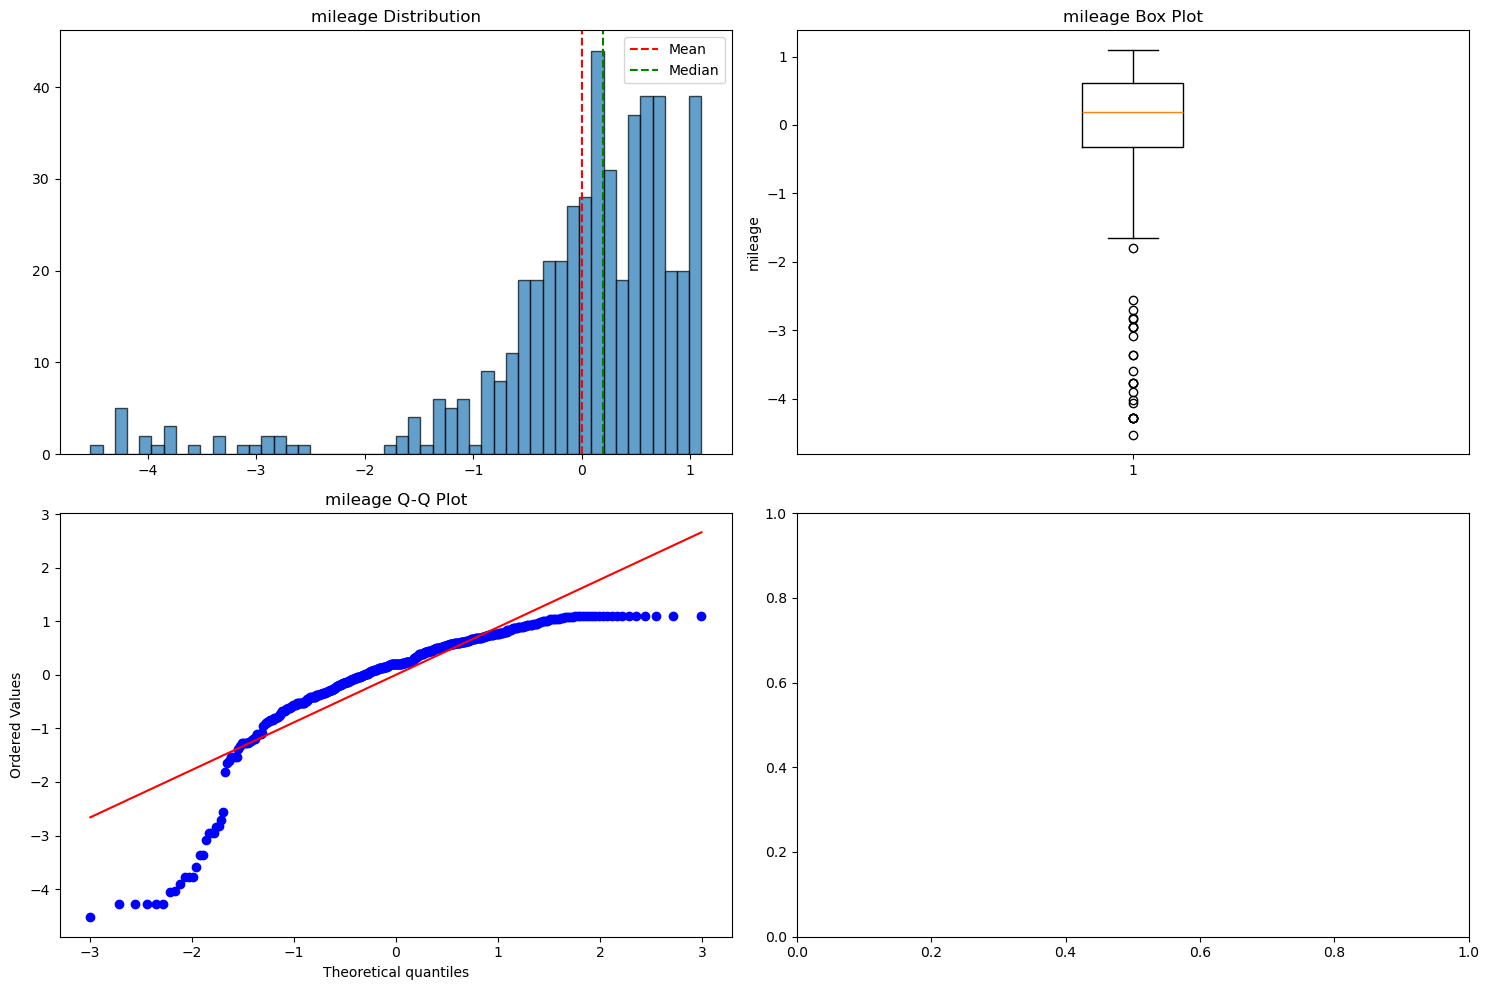


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset
⚠️  Highly left-skewed - consider power transformation

=== TRANSFORMATION EXPERIMENTS FOR MILEAGE ===
log1p_abs: Skewness -2.257 → 1.517
log1p_shifted: Skewness -2.257 → -3.308


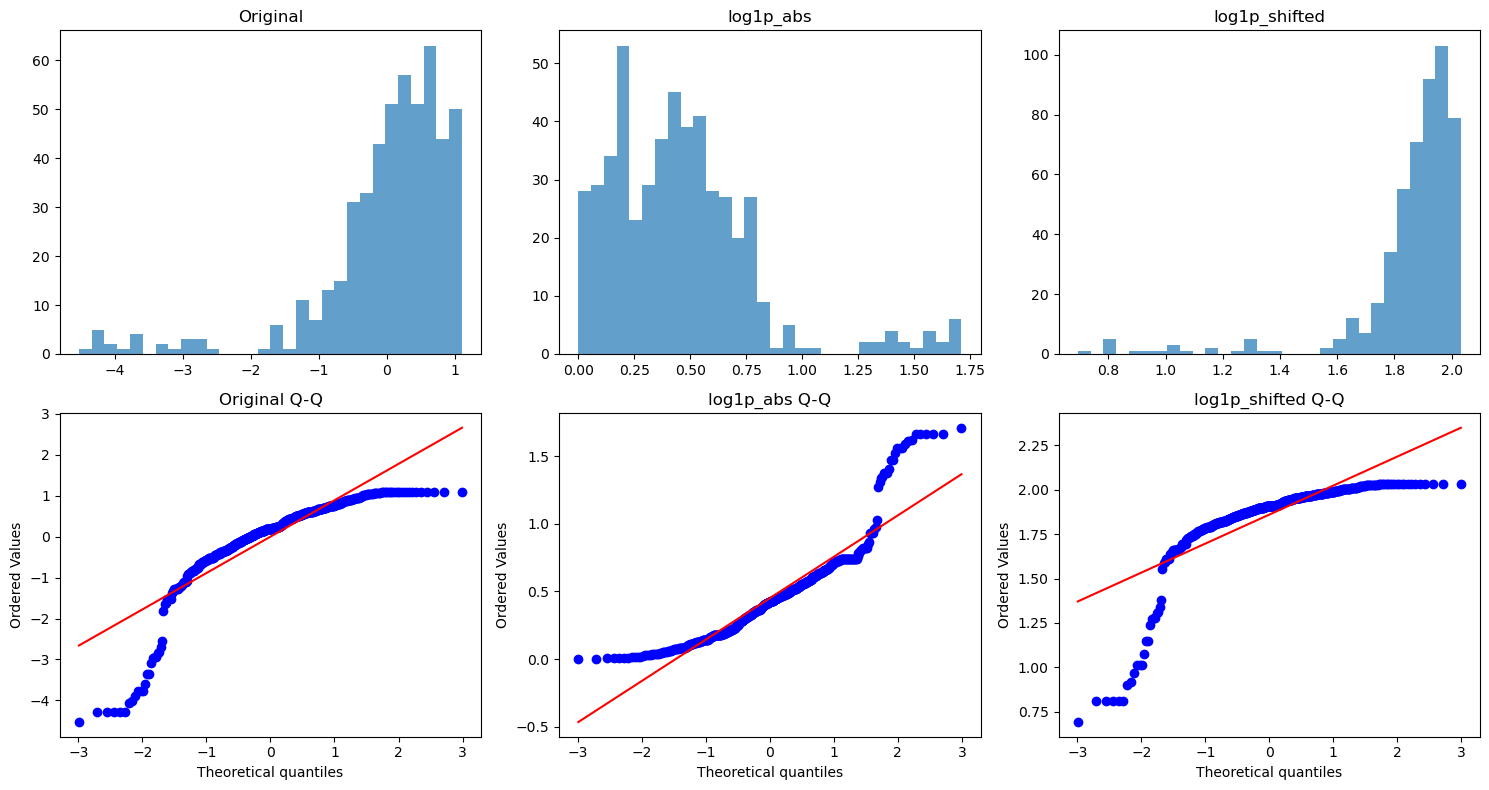







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: tax ---
--------------------------------------------------

ANALYZING: TAX
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: -2.5637514818871767
Max: 6.659331550051059
Mean: -0.000
Median: 0.365
Std: 1.001
Skewness: 0.017
Kurtosis: 3.802

=== DATA QUALITY ASSESSMENT ===
Negative values: 115 (23.00%)
Zero values: 0 (0.00%)
Outliers (IQR method): 147 (29.40%)


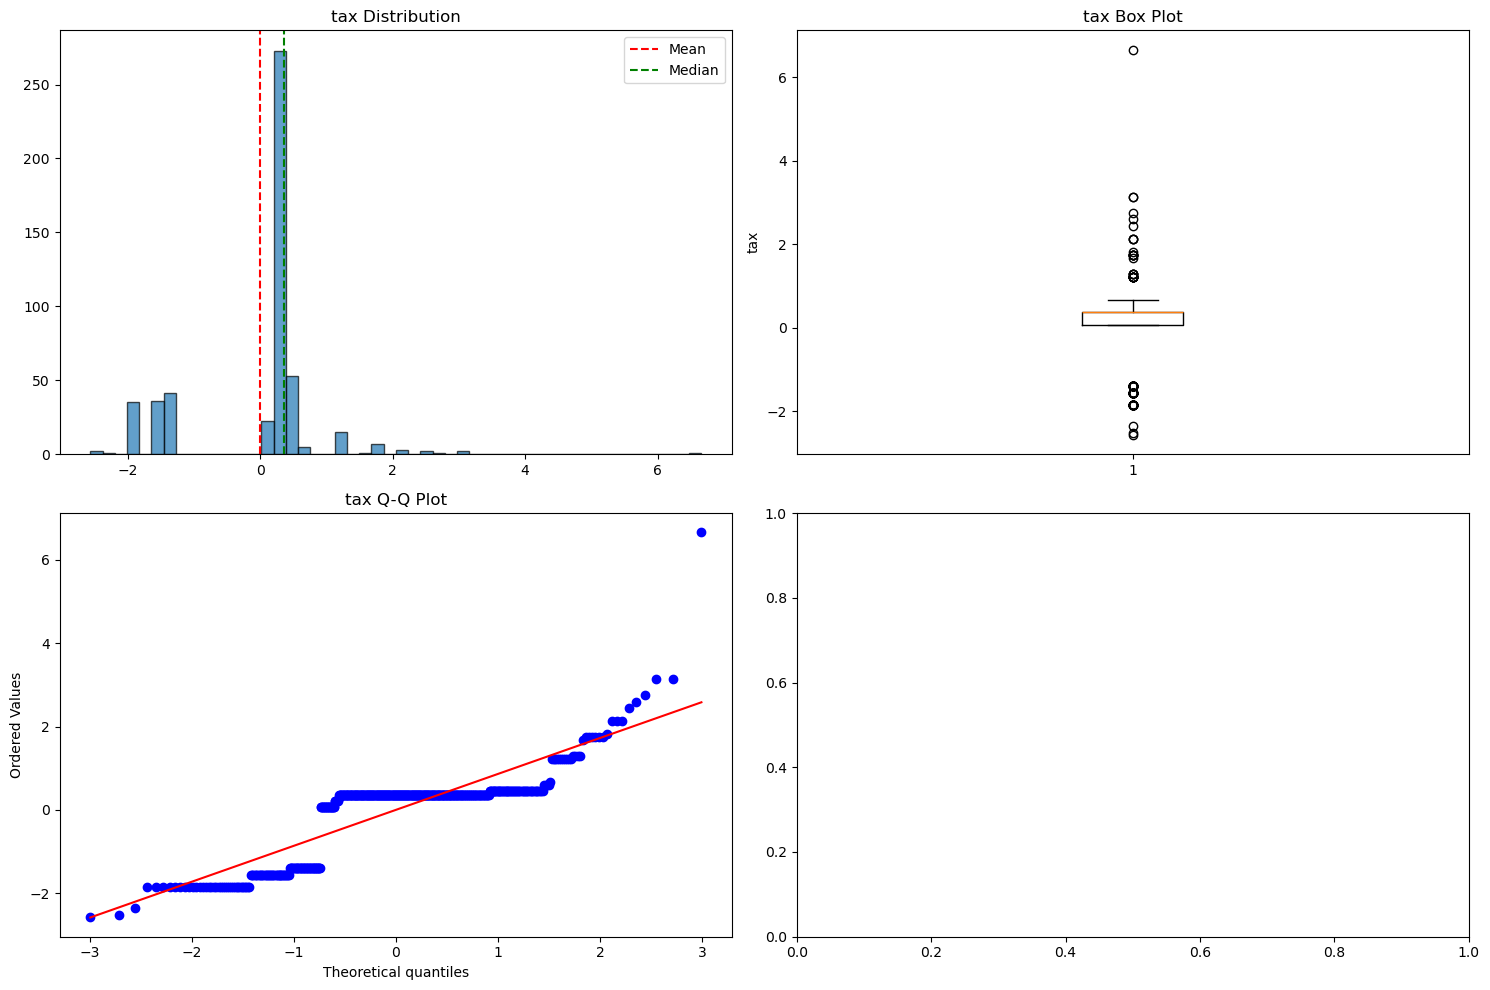


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset
⚠️  High percentage of outliers - consider outlier treatment

=== TRANSFORMATION EXPERIMENTS FOR TAX ===
log1p_abs: Skewness 0.017 → 1.064
log1p_shifted: Skewness 0.017 → -0.951


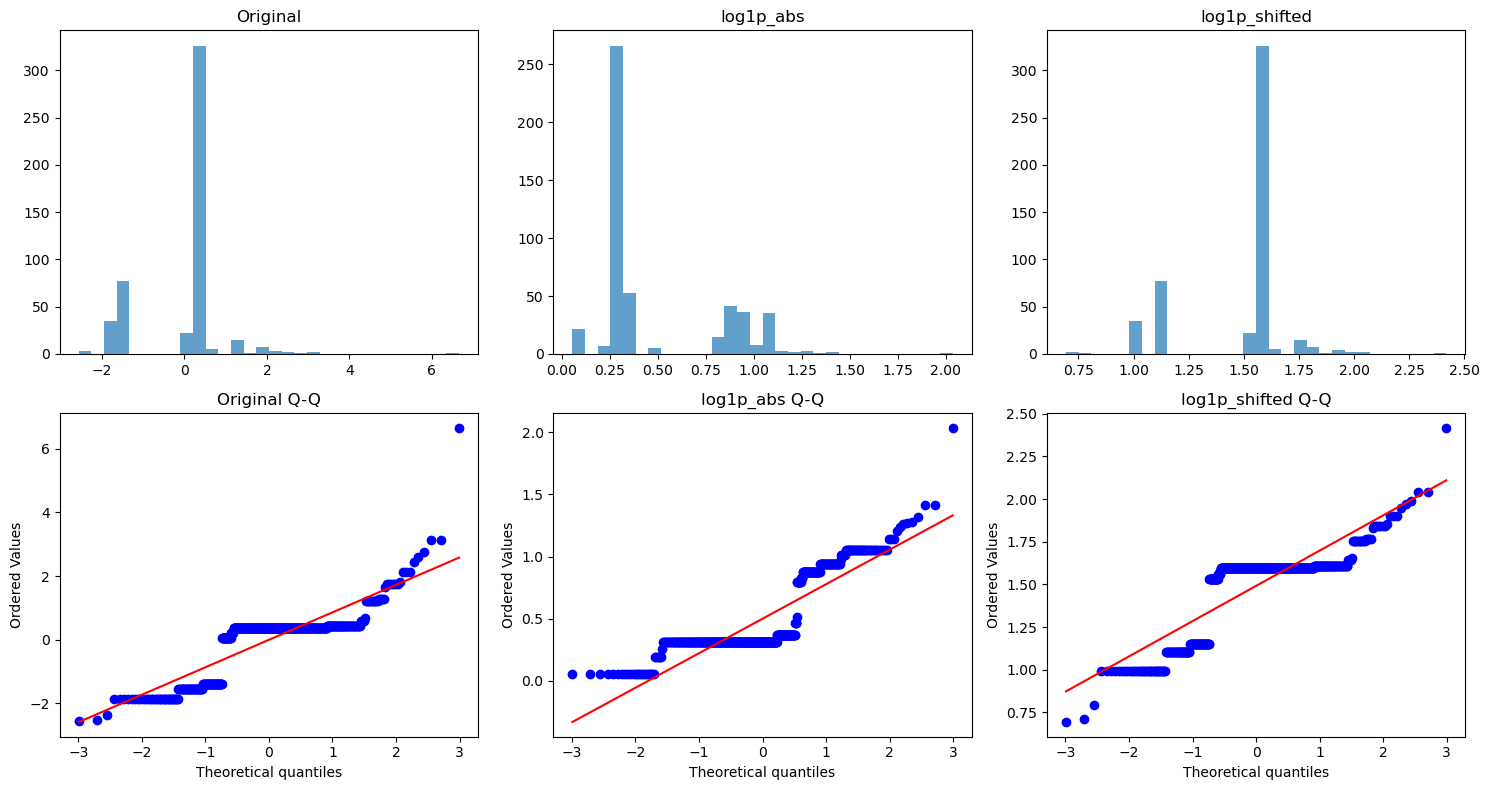







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: mpg ---
--------------------------------------------------

ANALYZING: MPG
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: -2.714662173154386
Max: 2.6970781941686948
Mean: -0.000
Median: -0.001
Std: 1.001
Skewness: 0.078
Kurtosis: 0.159

=== DATA QUALITY ASSESSMENT ===
Negative values: 277 (55.40%)
Zero values: 0 (0.00%)
Outliers (IQR method): 3 (0.60%)


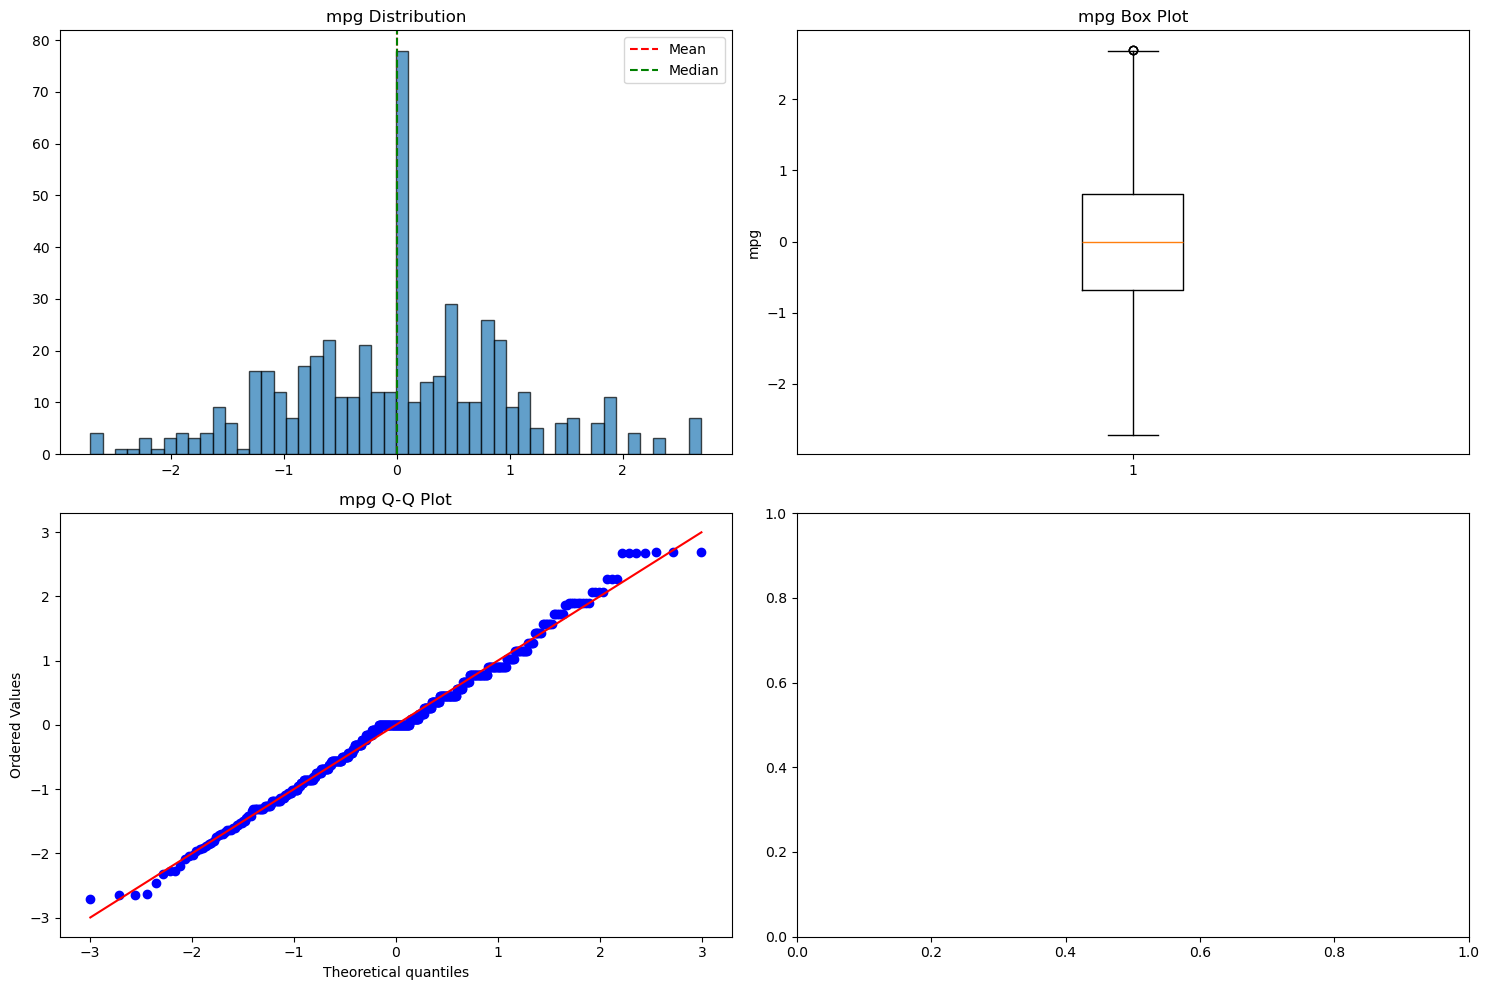


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset

=== TRANSFORMATION EXPERIMENTS FOR MPG ===
log1p_abs: Skewness 0.078 → 0.260
log1p_shifted: Skewness 0.078 → -0.686


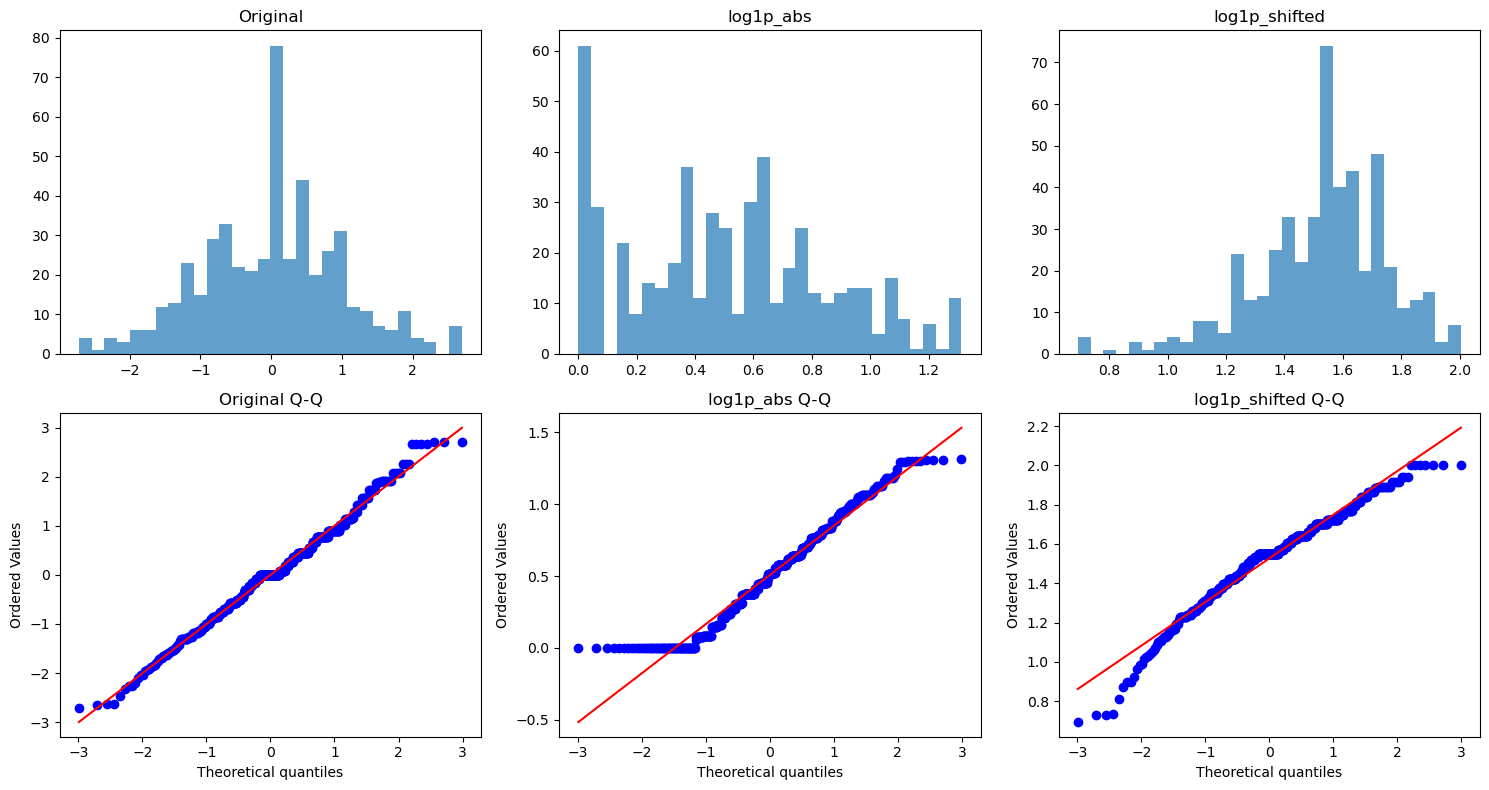







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: engineSize ---
--------------------------------------------------

ANALYZING: ENGINESIZE
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: -2.2857142857142856
Max: 6.571428571428571
Mean: 0.138
Median: 0.000
Std: 0.878
Skewness: 1.730
Kurtosis: 7.695

=== DATA QUALITY ASSESSMENT ===
Negative values: 231 (46.20%)
Zero values: 52 (10.40%)
Outliers (IQR method): 6 (1.20%)


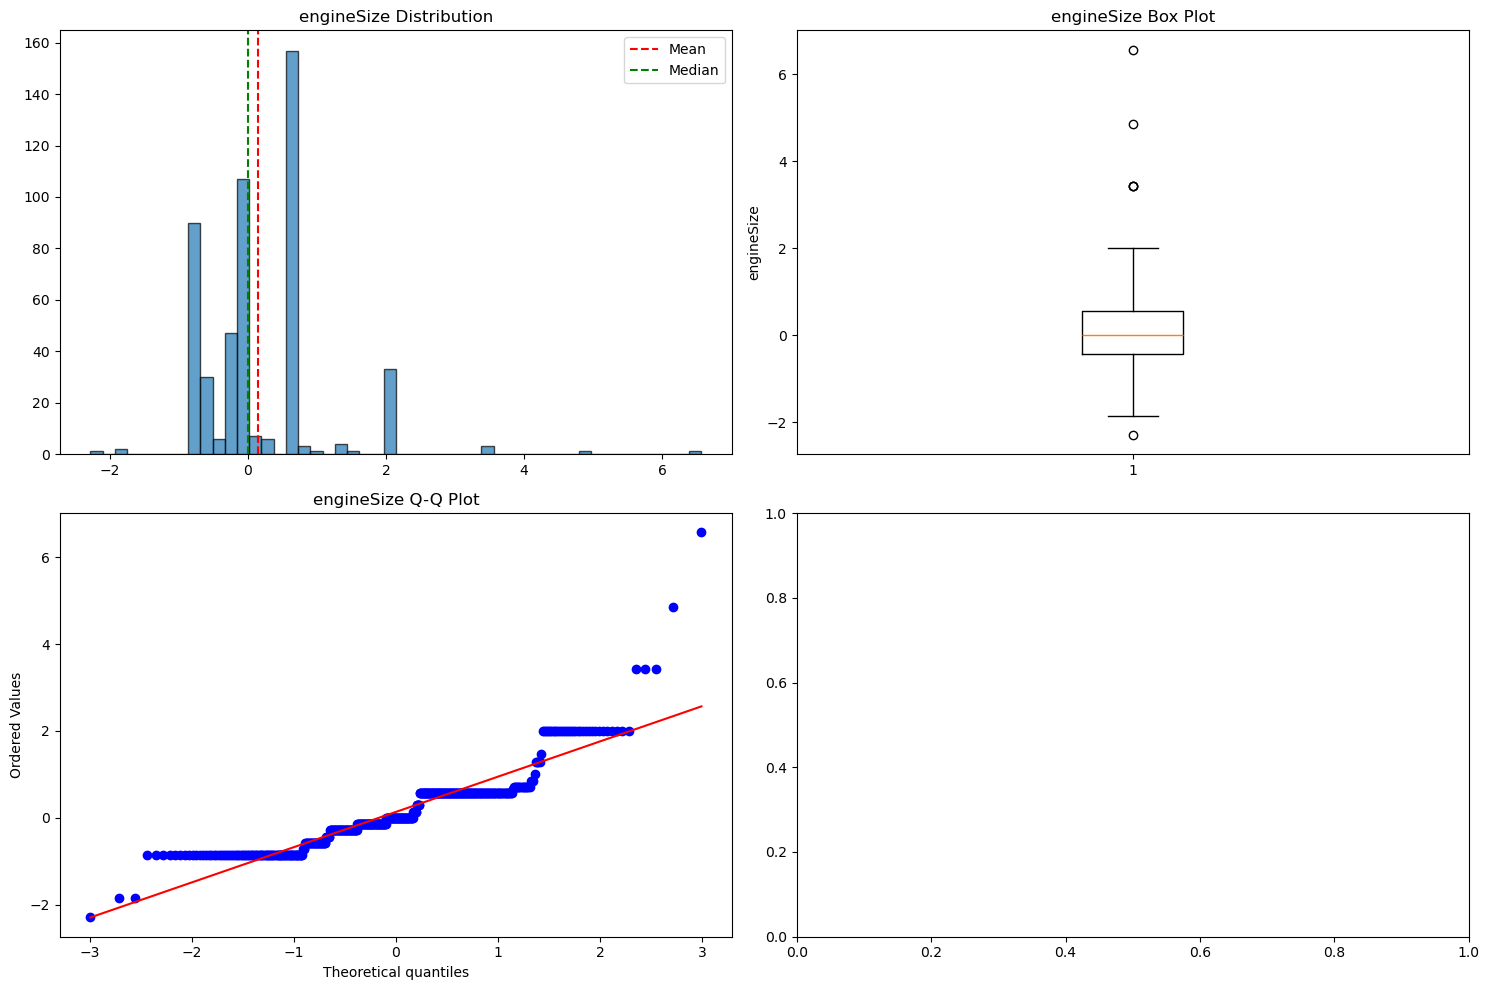


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset
⚠️  Highly right-skewed - consider log transformation
⚠️  Many zero values - consider log1p transformation

=== TRANSFORMATION EXPERIMENTS FOR ENGINESIZE ===
log1p_abs: Skewness 1.730 → 1.076
log1p_shifted: Skewness 1.730 → 0.497


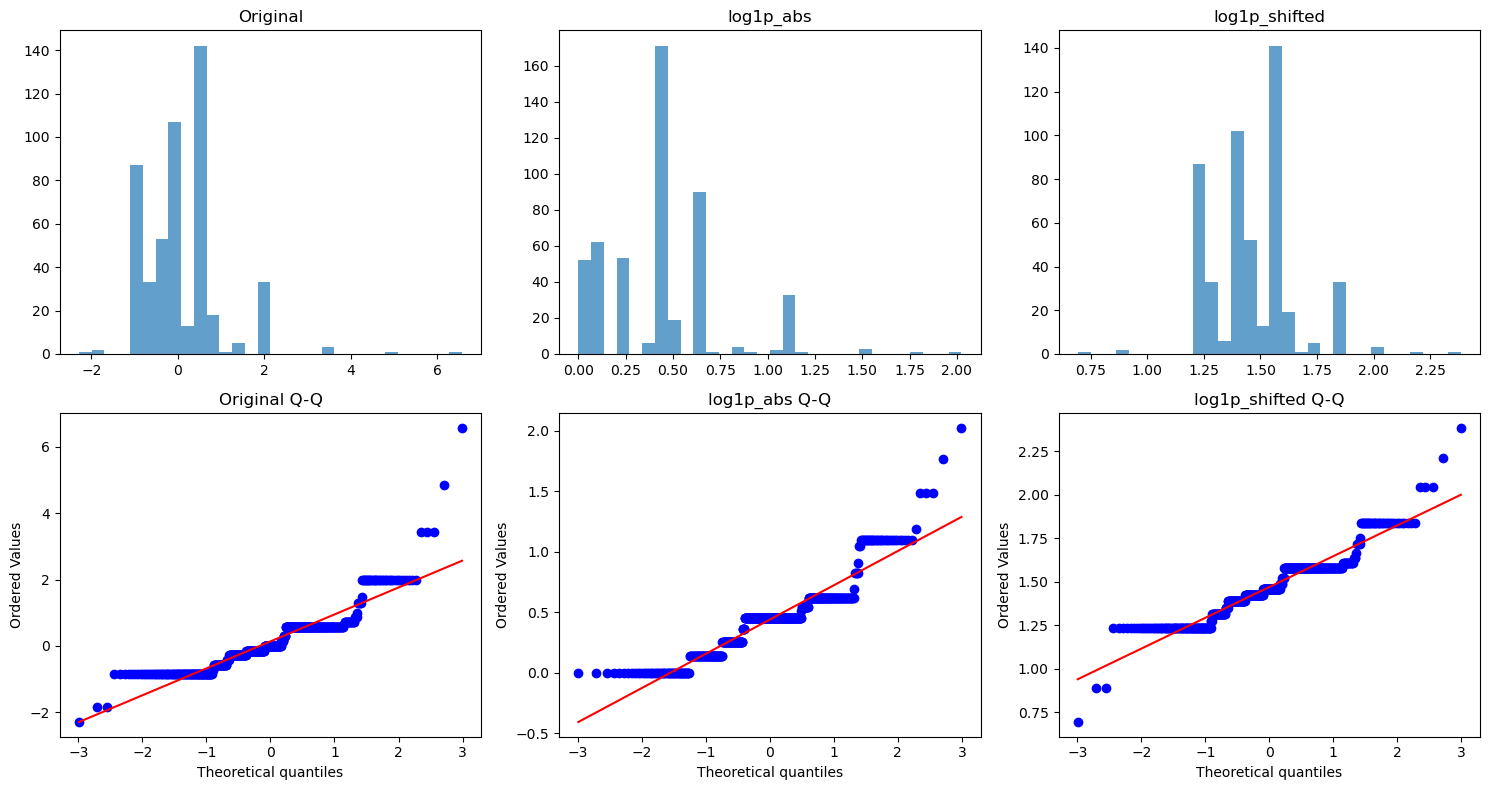







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: paintQuality% ---
--------------------------------------------------

ANALYZING: PAINTQUALITY%
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: 0.0
Max: 1.0
Mean: 0.633
Median: 0.644
Std: 0.211
Skewness: -0.150
Kurtosis: -0.738

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 1 (0.20%)
Outliers (IQR method): 0 (0.00%)


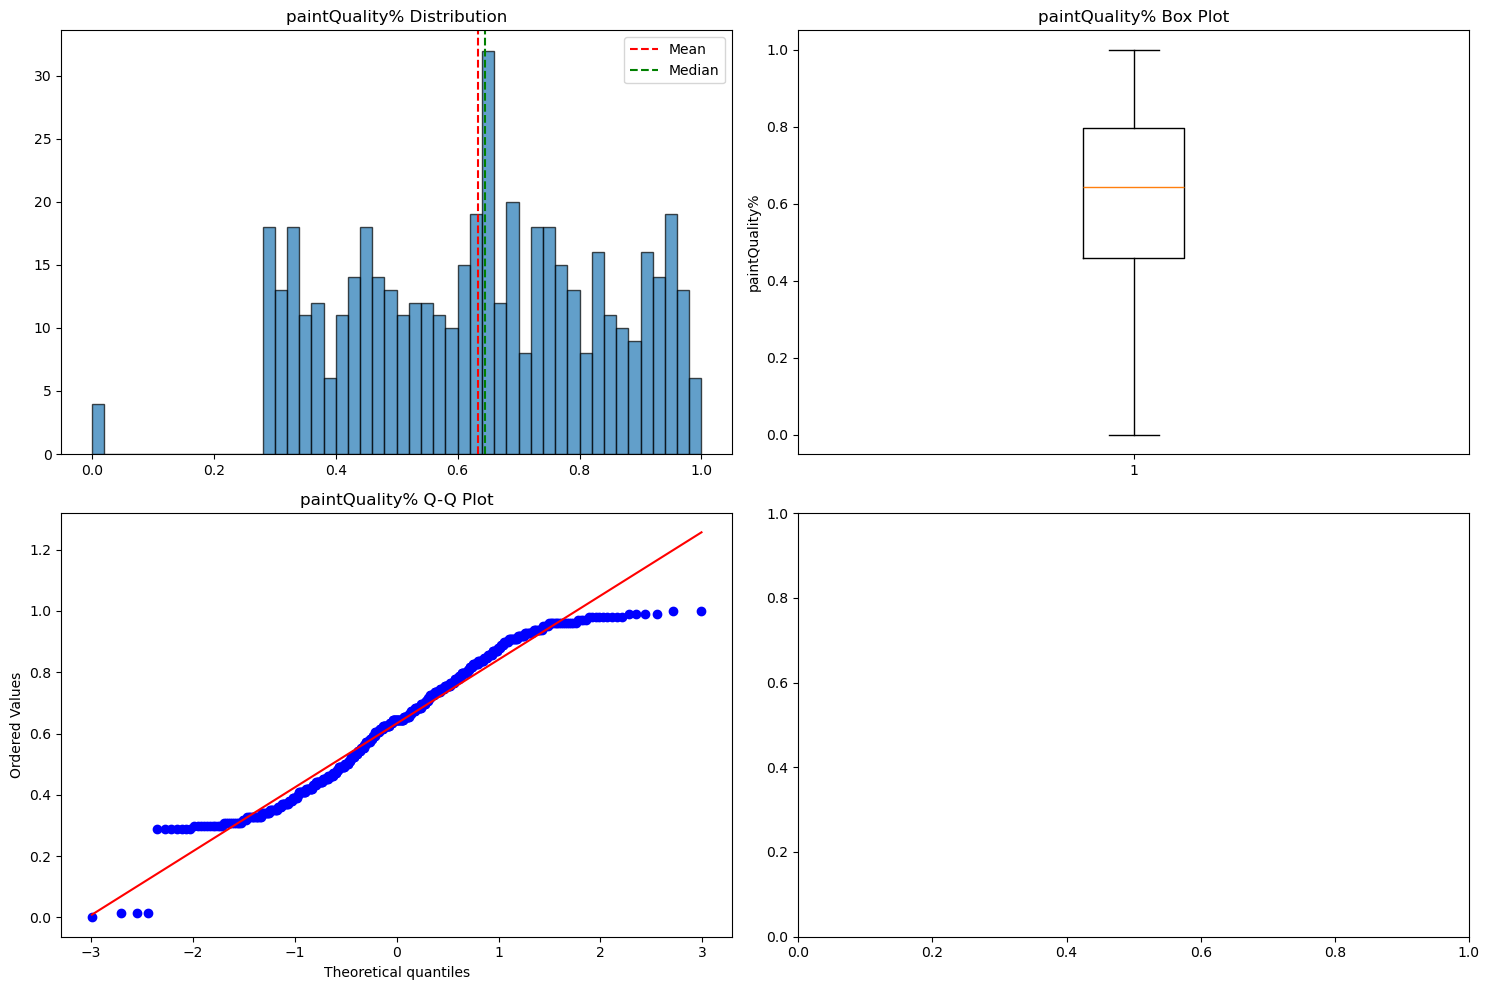


=== TRANSFORMATION SUGGESTIONS ===

=== TRANSFORMATION EXPERIMENTS FOR PAINTQUALITY% ===
log1p_abs: Skewness -0.150 → -0.436
log1p_shifted: Skewness -0.150 → -0.313
sqrt: Skewness -0.150 → -0.958


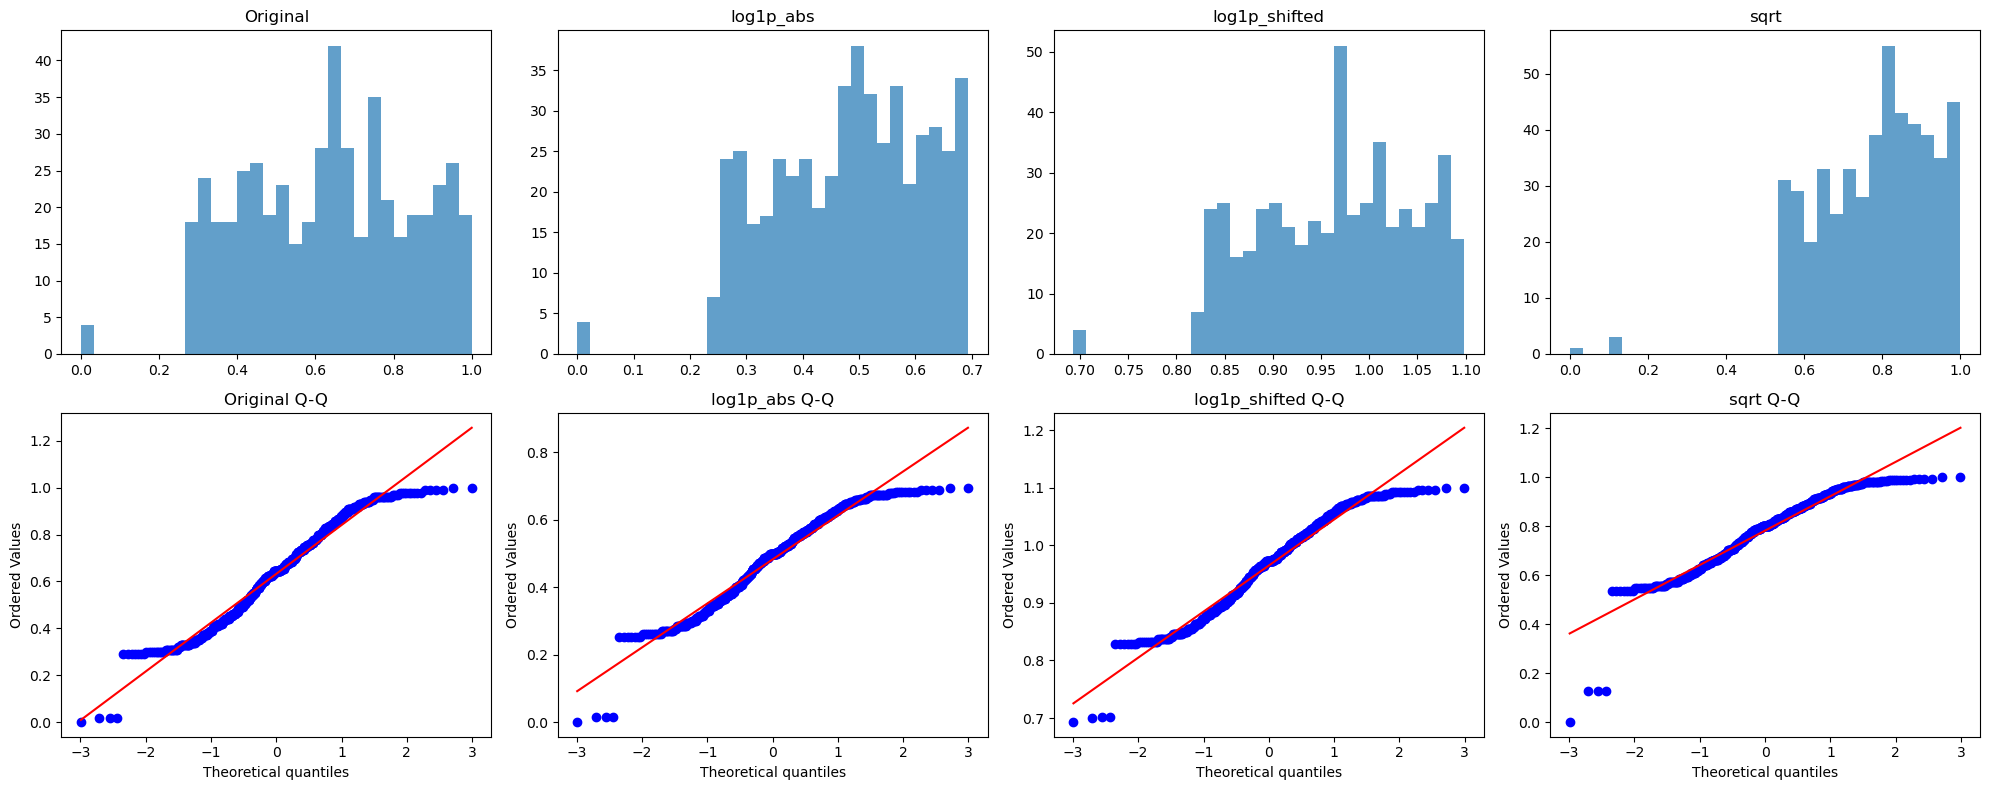







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: previousOwners ---
--------------------------------------------------

ANALYZING: PREVIOUSOWNERS
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: -1.6340906198520624
Max: 1.6767559230203275
Mean: 0.000
Median: 0.235
Std: 1.001
Skewness: -0.556
Kurtosis: -1.042

=== DATA QUALITY ASSESSMENT ===
Negative values: 196 (39.20%)
Zero values: 0 (0.00%)
Outliers (IQR method): 0 (0.00%)


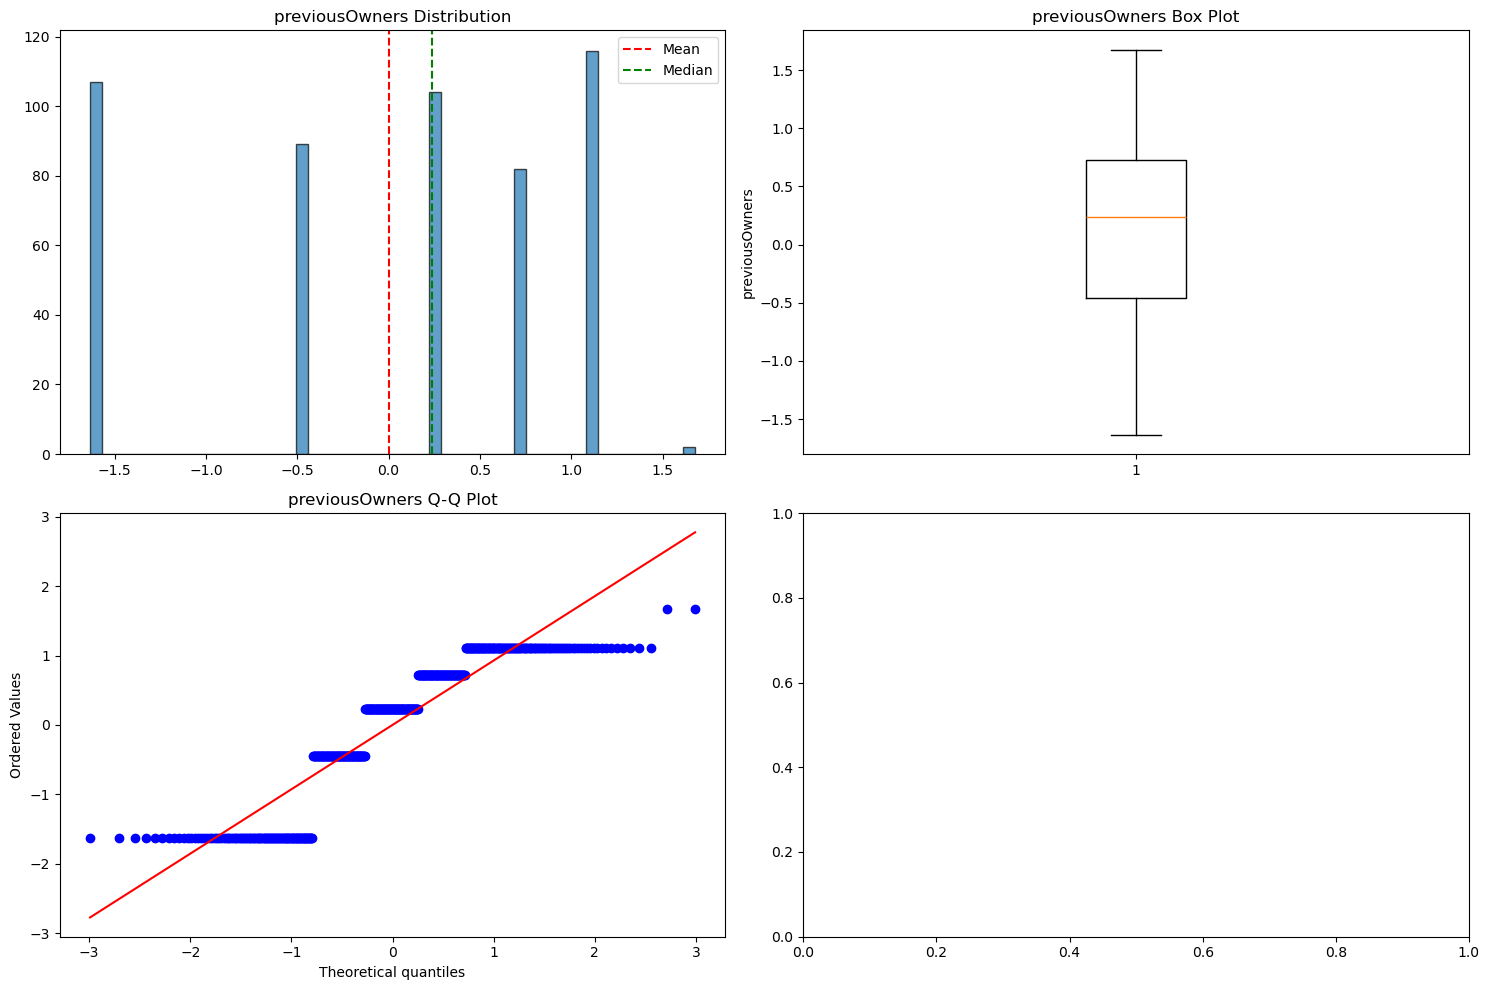


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Contains negative values - consider absolute transformation or offset

=== TRANSFORMATION EXPERIMENTS FOR PREVIOUSOWNERS ===
log1p_abs: Skewness -0.556 → 0.048
log1p_shifted: Skewness -0.556 → -0.835


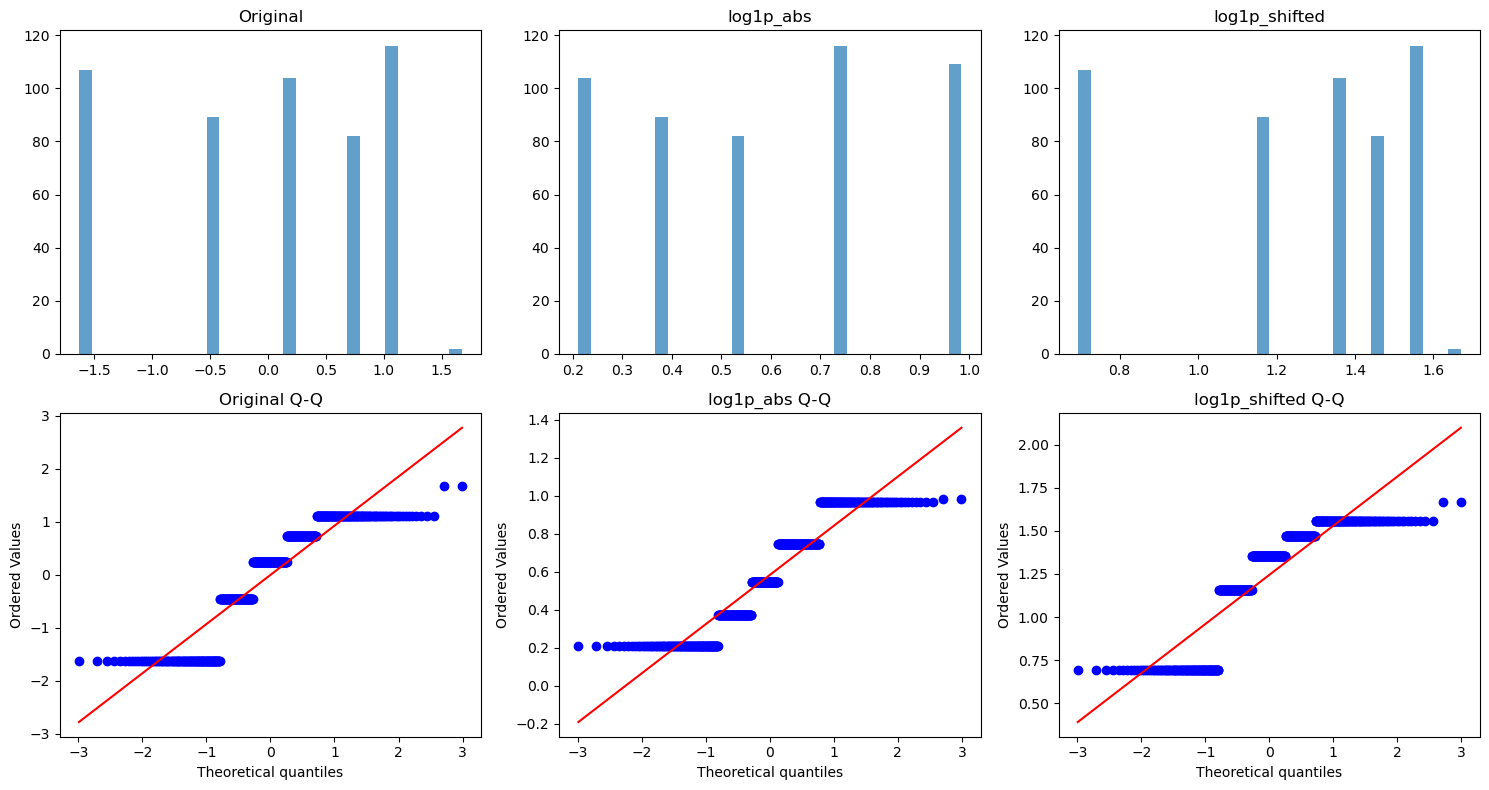







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: clean_make ---
--------------------------------------------------

ANALYZING: CLEAN_MAKE
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: 6295.0
Max: 44500.0
Mean: 17317.754
Median: 15914.610
Std: 5631.877
Skewness: 0.505
Kurtosis: -0.506

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 0 (0.00%)
Outliers (IQR method): 1 (0.20%)


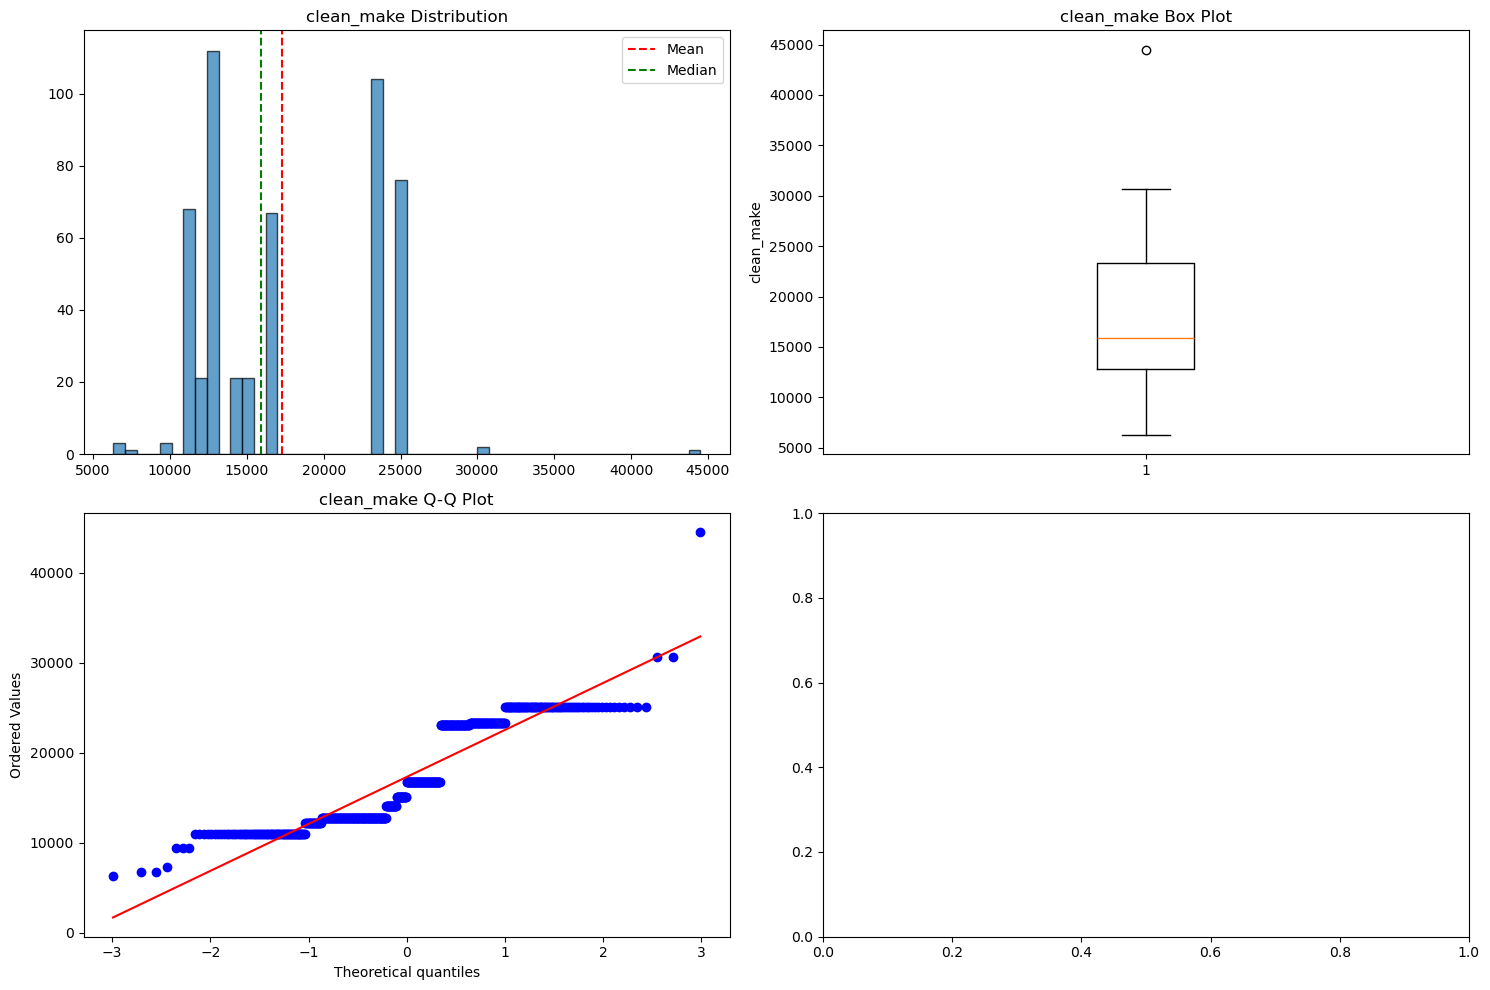


=== TRANSFORMATION SUGGESTIONS ===

=== TRANSFORMATION EXPERIMENTS FOR CLEAN_MAKE ===
log: Skewness 0.505 → 0.087
log1p: Skewness 0.505 → 0.087
sqrt: Skewness 0.505 → 0.290
boxcox_λ=-0.155: Skewness 0.505 → 0.018


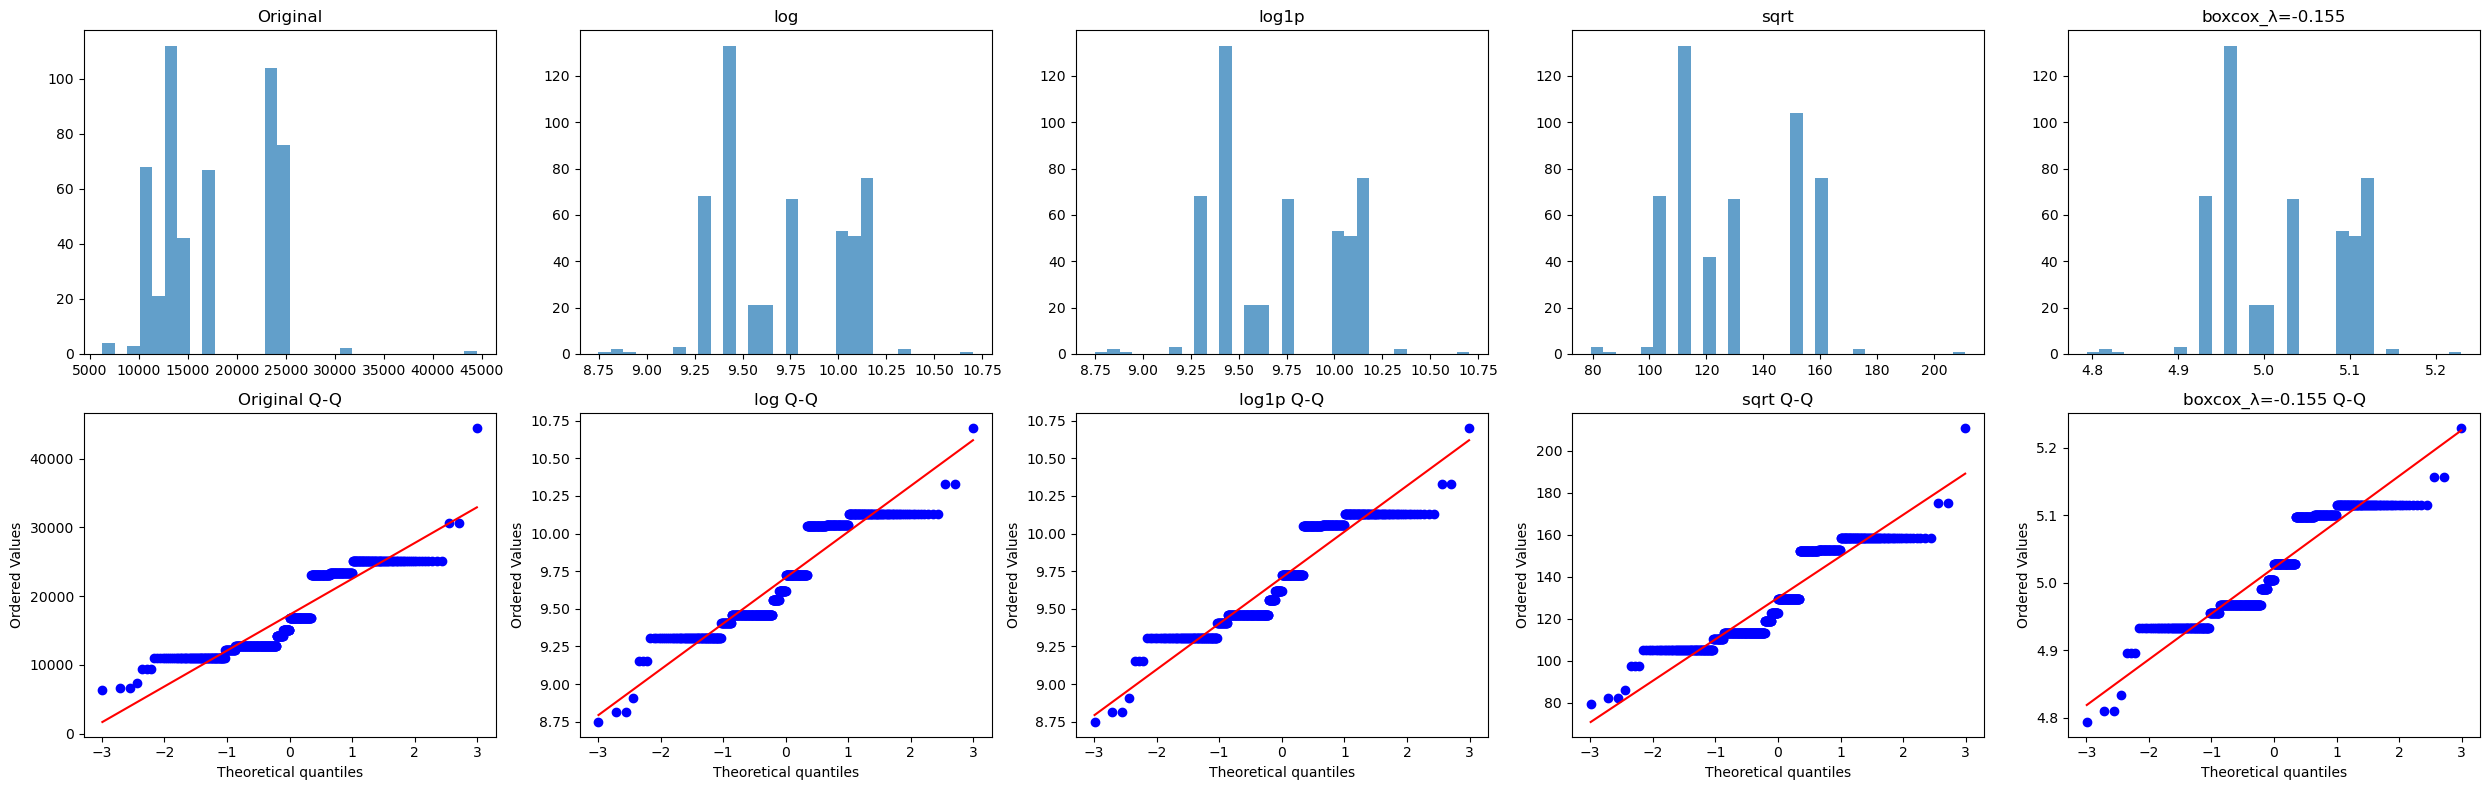







--------------------------------------------------
--- ANALYZING NUMERICAL FEATURE: clean_model ---
--------------------------------------------------

ANALYZING: CLEAN_MODEL
=== BASIC STATISTICS ===
Count: 500
Missing: 0
Missing %: 0.000
Min: 5950.0
Max: 59995.0
Mean: 17317.754
Median: 14280.615
Std: 8722.050
Skewness: 1.658
Kurtosis: 3.340

=== DATA QUALITY ASSESSMENT ===
Negative values: 0 (0.00%)
Zero values: 0 (0.00%)
Outliers (IQR method): 19 (3.80%)


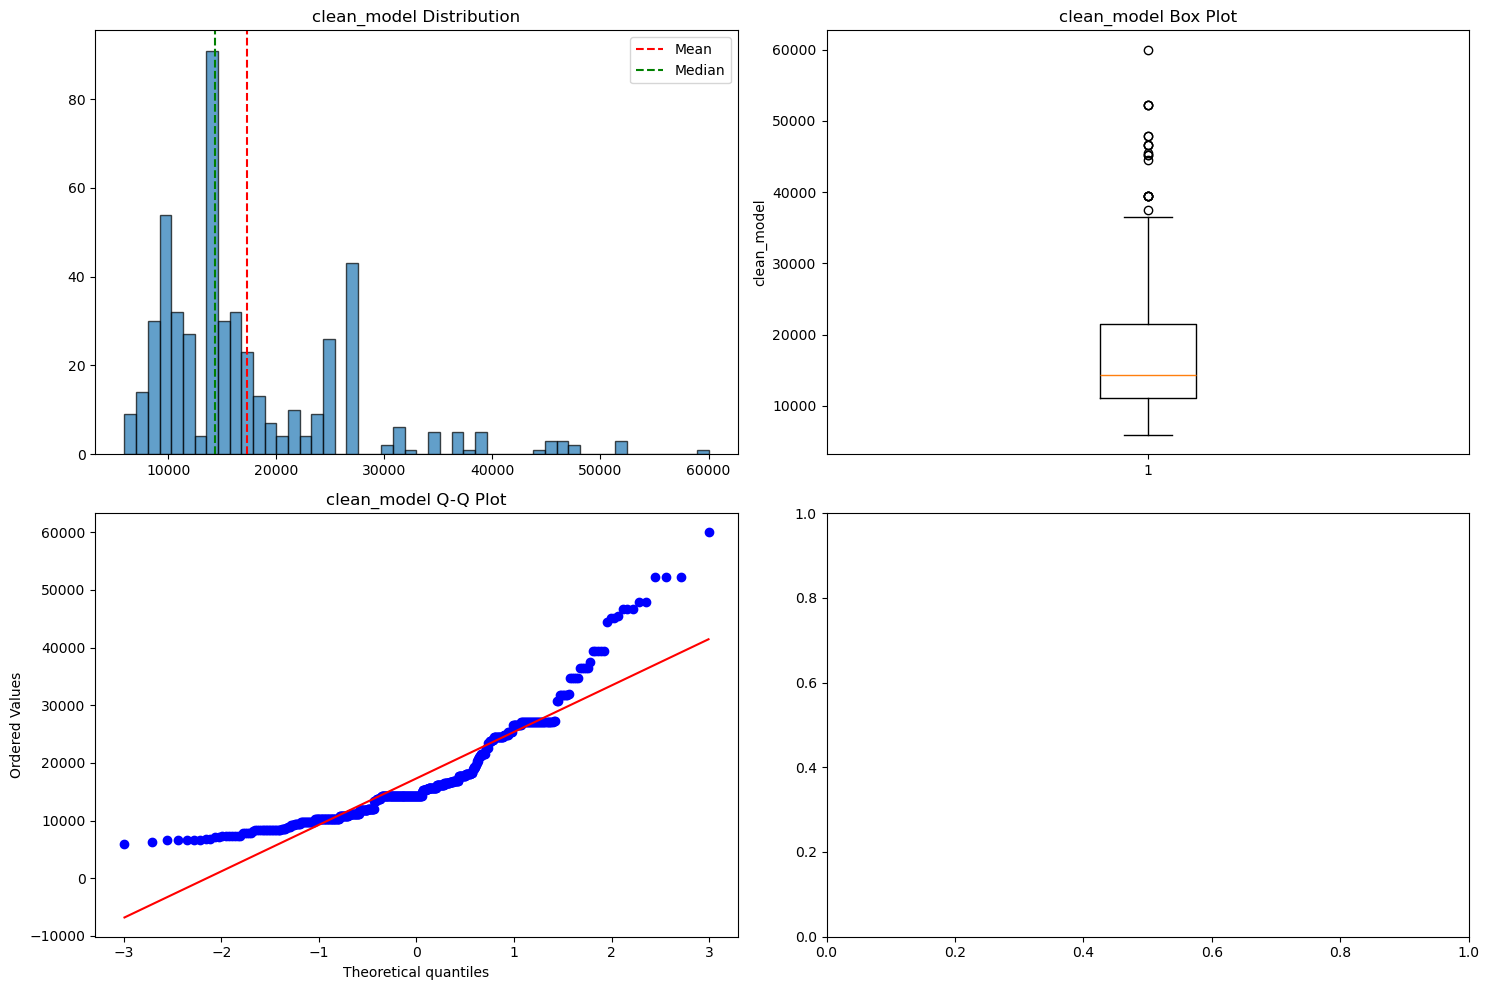


=== TRANSFORMATION SUGGESTIONS ===
⚠️  Highly right-skewed - consider log transformation

=== TRANSFORMATION EXPERIMENTS FOR CLEAN_MODEL ===
log: Skewness 1.658 → 0.439
log1p: Skewness 1.658 → 0.439
sqrt: Skewness 1.658 → 1.013
boxcox_λ=-0.389: Skewness 1.658 → 0.026


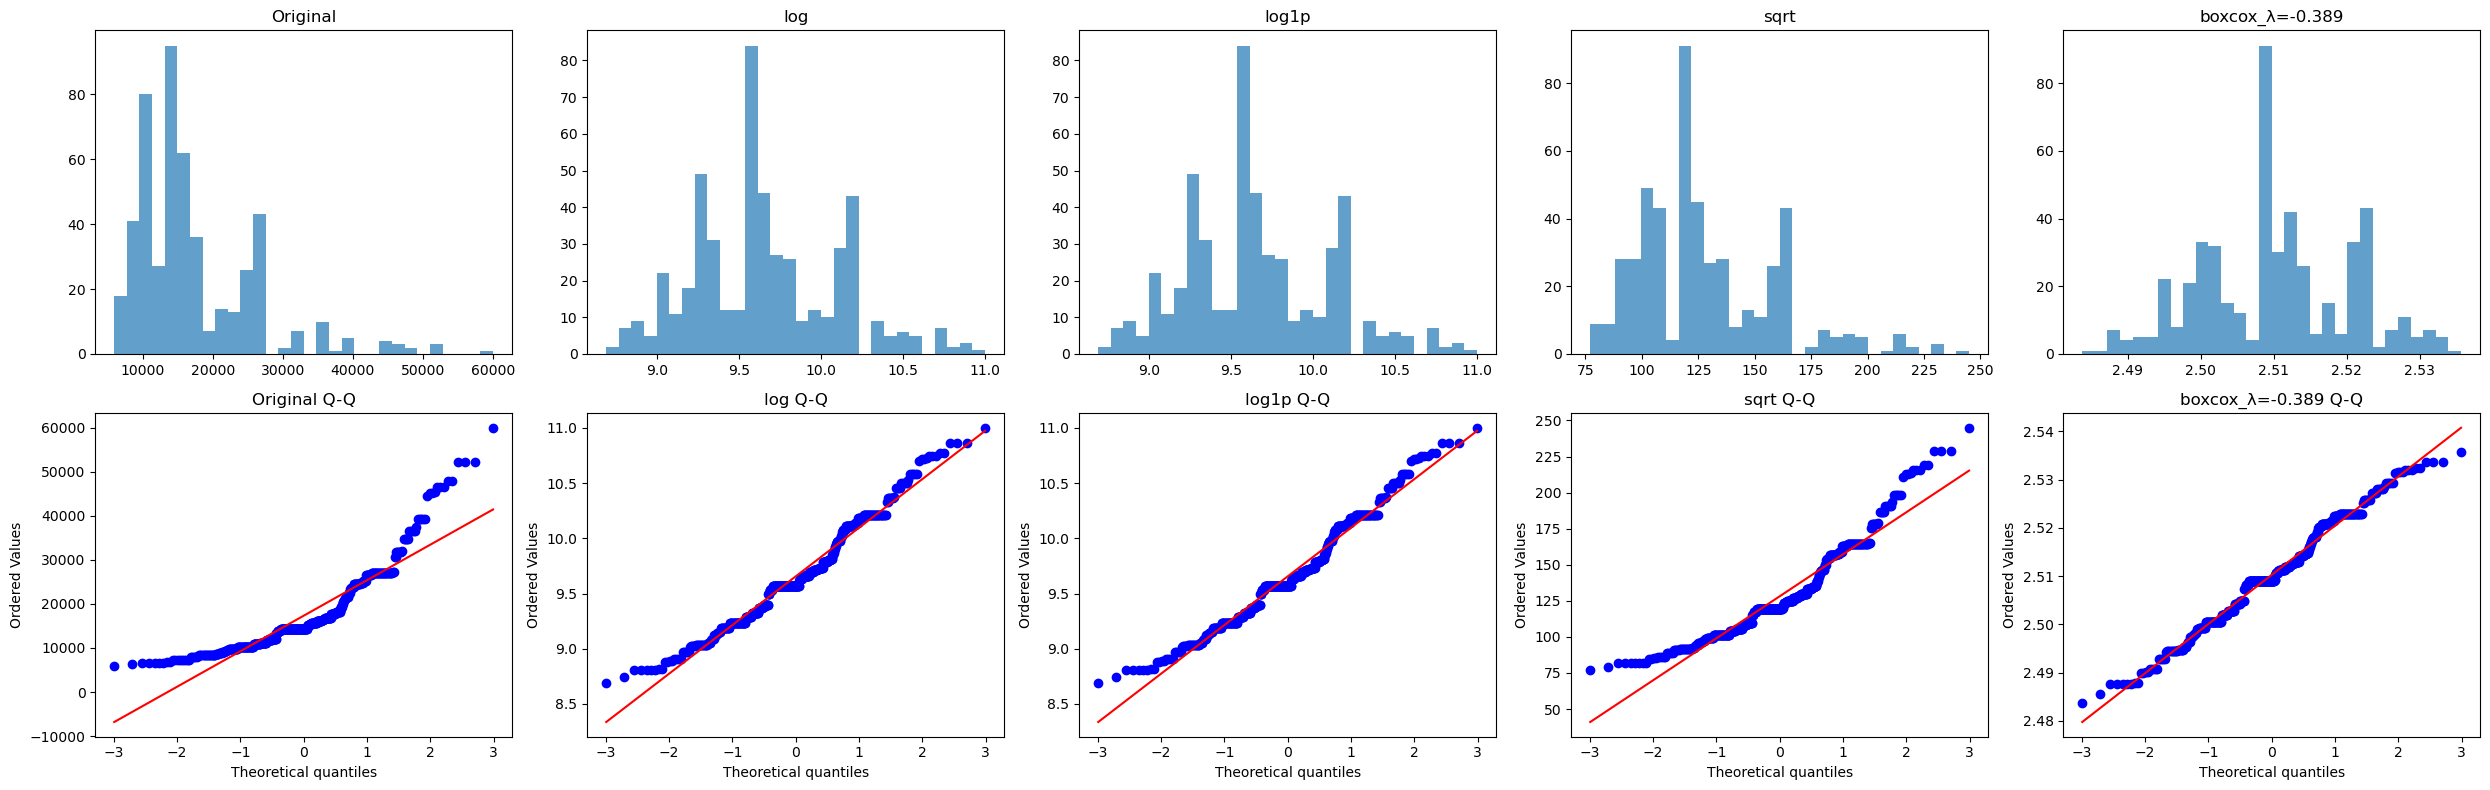

In [11]:
boolean_features = X_train.columns[X_train.nunique() == 2].tolist()
numerical_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
numerical_features = [feat for feat in numerical_features if feat not in boolean_features]
for feature in numerical_features:
    print("-"*50)
    print(f"--- ANALYZING NUMERICAL FEATURE: {feature} ---")
    print("-"*50)
    analyze_numerical_feature(X_train, feature)
    suggest_transformations(X_train, feature)
    
    print("\n\n\n\n\n")


## Analize Categorical Features

--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: transmission ---
--------------------------------------------------

ANALYZING: TRANSMISSION
=== BASIC STATISTICS ===
Total records: 500
Missing values: 0 (0.00%)
Unique values: 4
Cardinality ratio: 0.008

=== TOP 4 VALUES ===
transmission
Manual       271
Automatic    113
Semi-Auto     99
Other         17
Name: count, dtype: int64


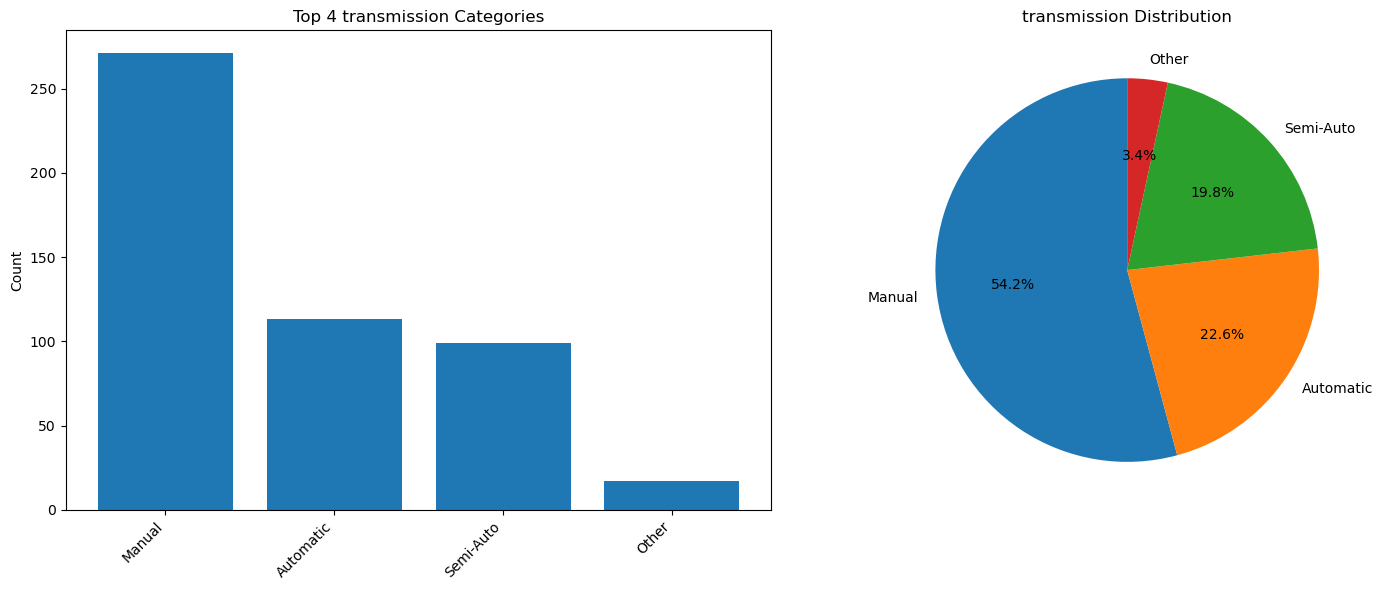


=== DATA QUALITY ASSESSMENT ===

=== ENCODING SUGGESTIONS ===
✓ Low cardinality - use One-Hot Encoding


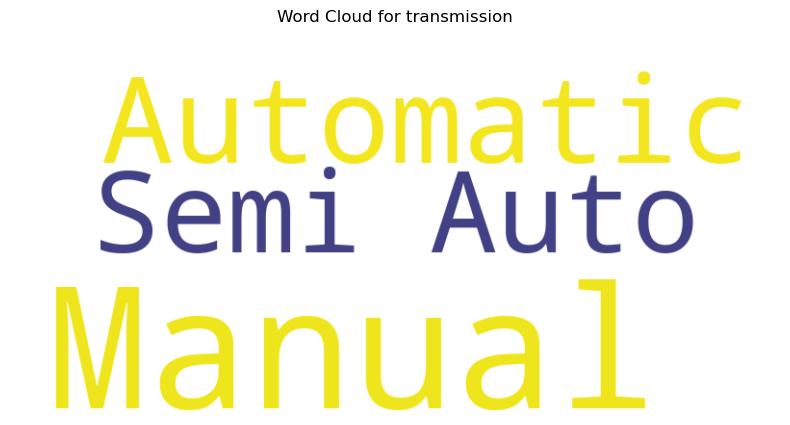







--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: fuelType ---
--------------------------------------------------

ANALYZING: FUELTYPE
=== BASIC STATISTICS ===
Total records: 500
Missing values: 0 (0.00%)
Unique values: 4
Cardinality ratio: 0.008

=== TOP 4 VALUES ===
fuelType
Petrol    266
Diesel    209
Hybrid     15
Other      10
Name: count, dtype: int64


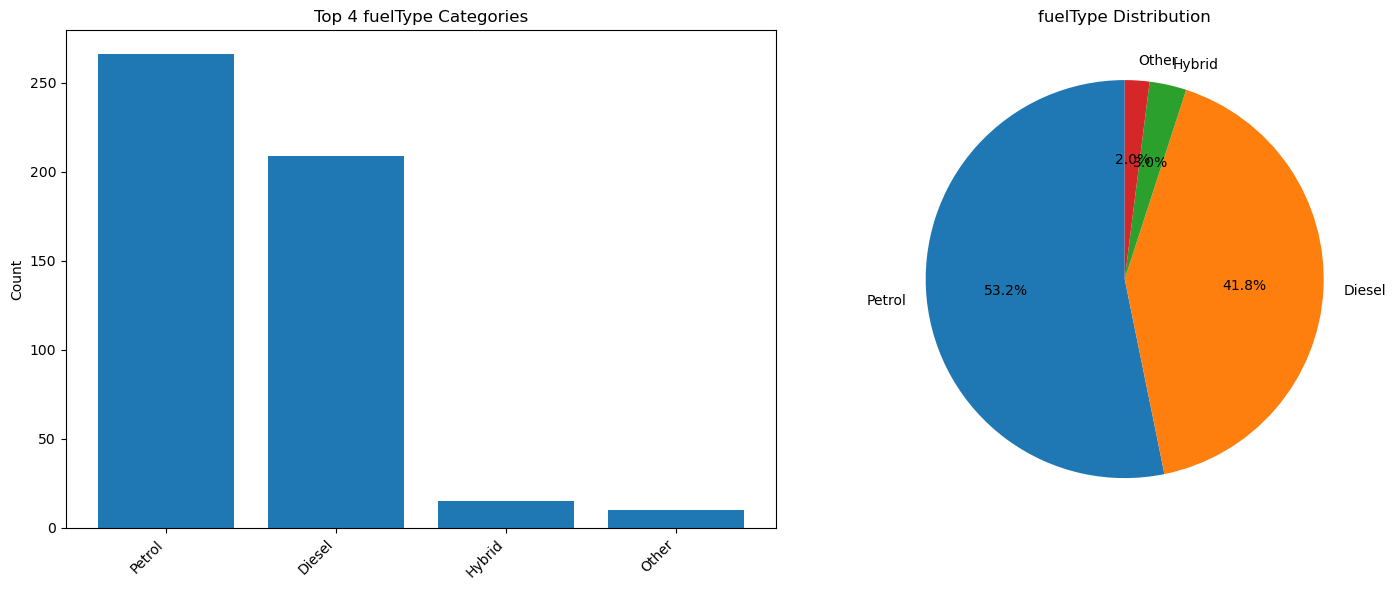


=== DATA QUALITY ASSESSMENT ===

=== ENCODING SUGGESTIONS ===
✓ Low cardinality - use One-Hot Encoding


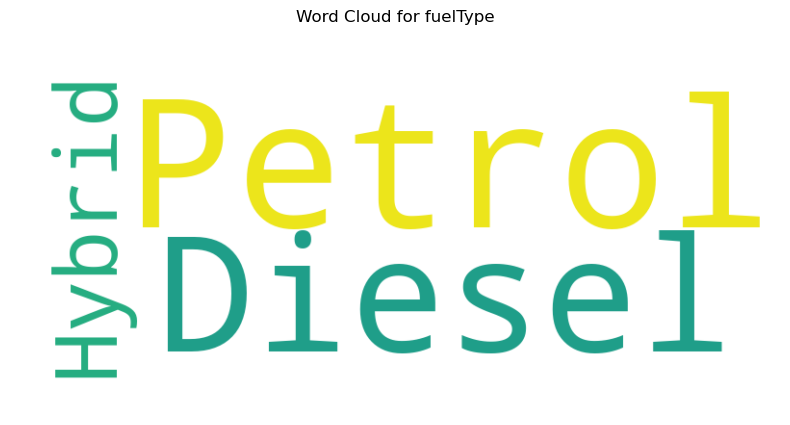







--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: clean_make ---
--------------------------------------------------

ANALYZING: CLEAN_MAKE
=== BASIC STATISTICS ===
Total records: 500
Missing values: 6 (1.20%)
Unique values: 15
Cardinality ratio: 0.030

=== TOP 16 VALUES ===
clean_make
ford             106
mercedes-benz     76
opel              68
volkswagen        67
bmw               53
audi              51
skoda             21
hyundai           21
toyota            21
None               6
ferrari            3
infiniti           2
chevrolet          2
aston martin       1
bentley            1
plymouth           1
Name: count, dtype: int64


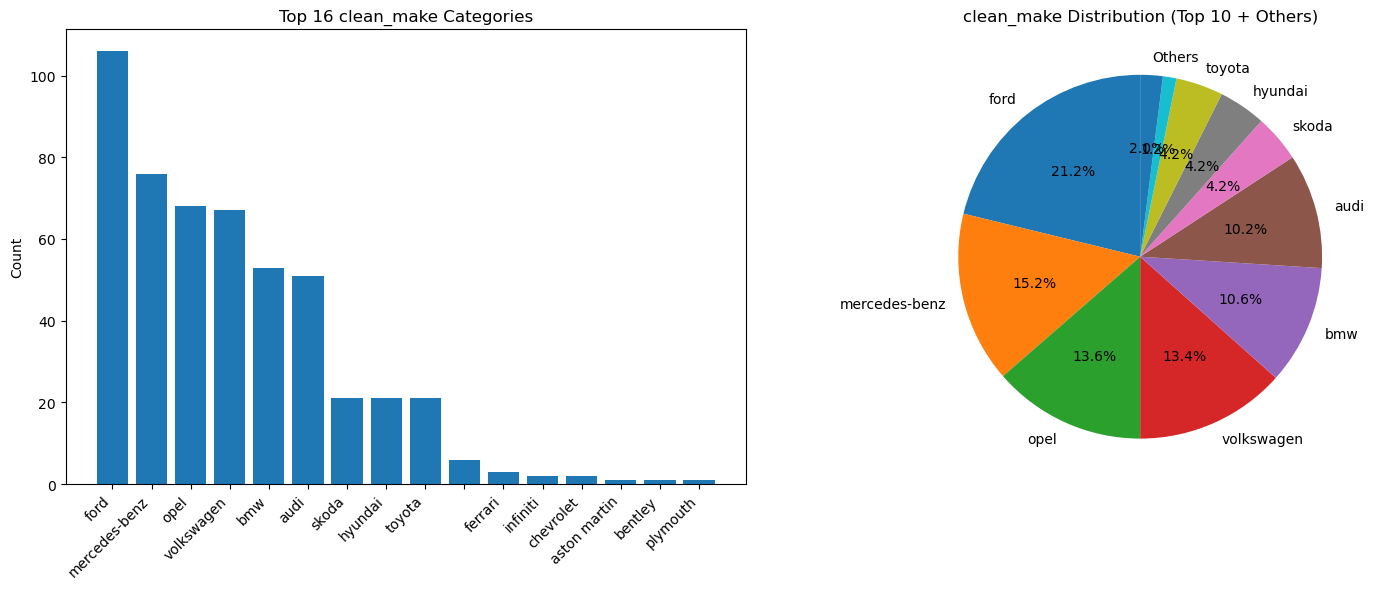


=== DATA QUALITY ASSESSMENT ===
⚠️  High cardinality feature - check for spelling variations
⚠️  6 rare categories (< 1.0% of data)
Consider grouping into 'Other' category

=== ENCODING SUGGESTIONS ===
⚠️  Medium cardinality - consider Target Encoding or Ordinal Encoding


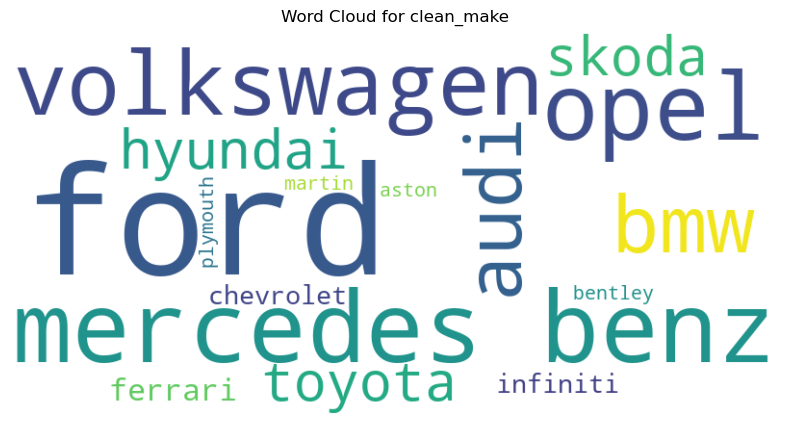







--------------------------------------------------
--- ANALYZING CATEGORICAL FEATURE: clean_model ---
--------------------------------------------------

ANALYZING: CLEAN_MODEL
=== BASIC STATISTICS ===
Total records: 500
Missing values: 39 (7.80%)
Unique values: 86
Cardinality ratio: 0.172

=== TOP 20 VALUES ===
clean_model
None            39
focus           39
fiesta          33
c class         31
golf            17
polo            16
astra           14
3 series        13
a class         13
corsa           12
mokka           12
yaris           10
a1              10
e class         10
tiguan           9
ecosport awd     7
crossland        7
a4               7
2 series         7
5 series         7
Name: count, dtype: int64


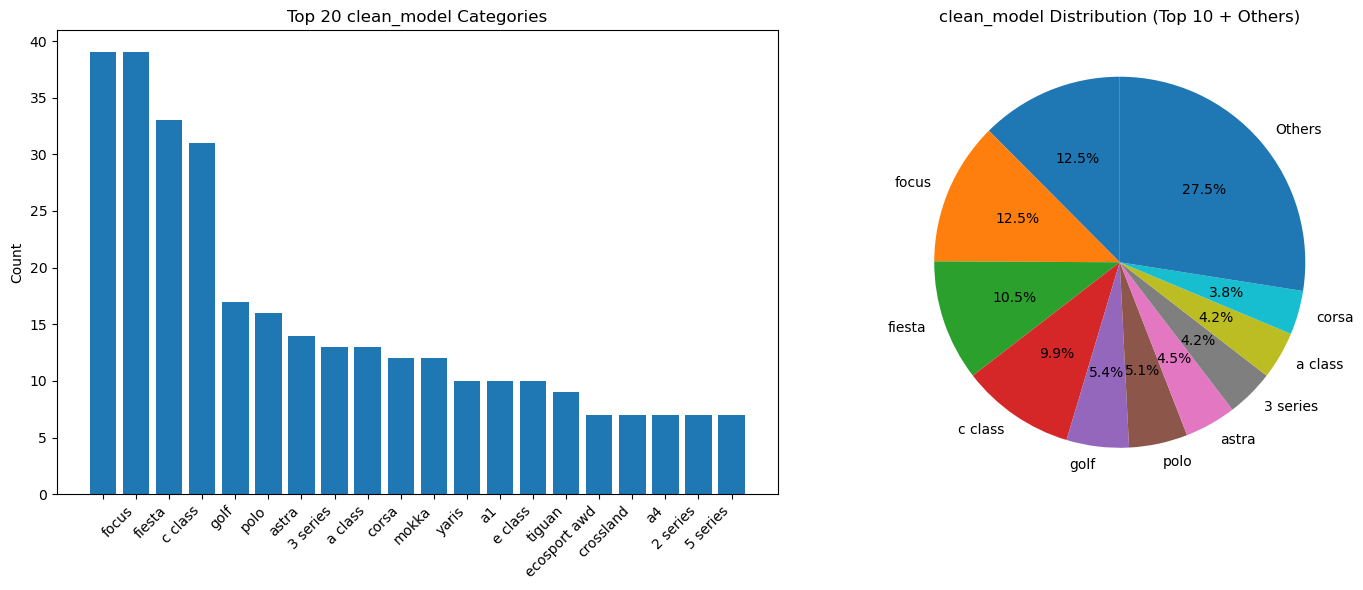


=== DATA QUALITY ASSESSMENT ===
⚠️  High cardinality feature - check for spelling variations
⚠️  54 rare categories (< 1.0% of data)
Consider grouping into 'Other' category

=== ENCODING SUGGESTIONS ===
⚠️  High cardinality - consider:
  - Target/Mean Encoding
  - Feature hashing
  - Dimensionality reduction
  - Grouping rare categories


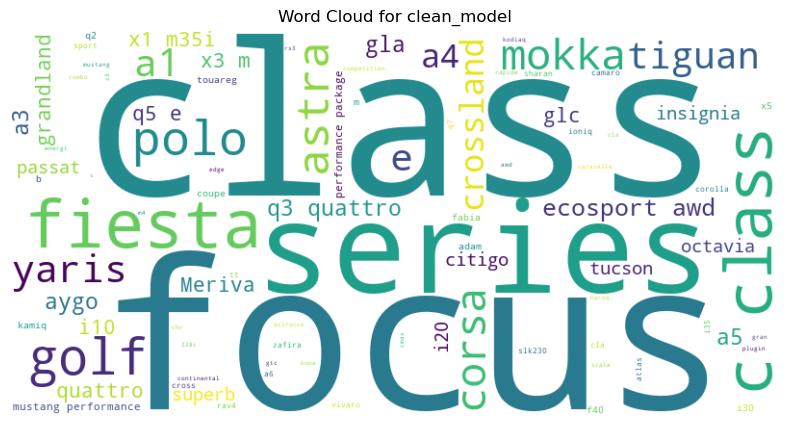

In [12]:
categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
for feature in categorical_features:
    print("-"*50)
    print(f"--- ANALYZING CATEGORICAL FEATURE: {feature} ---")
    print("-"*50)
    analyze_categorical_feature(train_data, feature)
    # Plot the word cloud   
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(train_data[feature].dropna().astype(str)))
    plt.figure(figsize=(10, 5))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {feature}")
    plt.show()
    
    print("\n\n\n\n\n")

## Analize Boolean Features

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: hasDamage ---
--------------------------------------------------
Value counts for hasDamage:
hasDamage
0.0    487
1.0     13
Name: count, dtype: int64

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: transmission_Automatic ---
--------------------------------------------------
Value counts for transmission_Automatic:
transmission_Automatic
0.0    387
1.0    113
Name: count, dtype: int64

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: transmission_Manual ---
--------------------------------------------------
Value counts for transmission_Manual:
transmission_Manual
1.0    271
0.0    229
Name: count, dtype: int64

--------------------------------------------------
--- ANALYZING BOOLEAN FEATURE: transmission_Other ---
--------------------------------------------------
Value counts for transmission_Other:
transmission_Other
0.0    483
1.0   

IndexError: index 8 is out of bounds for axis 0 with size 8

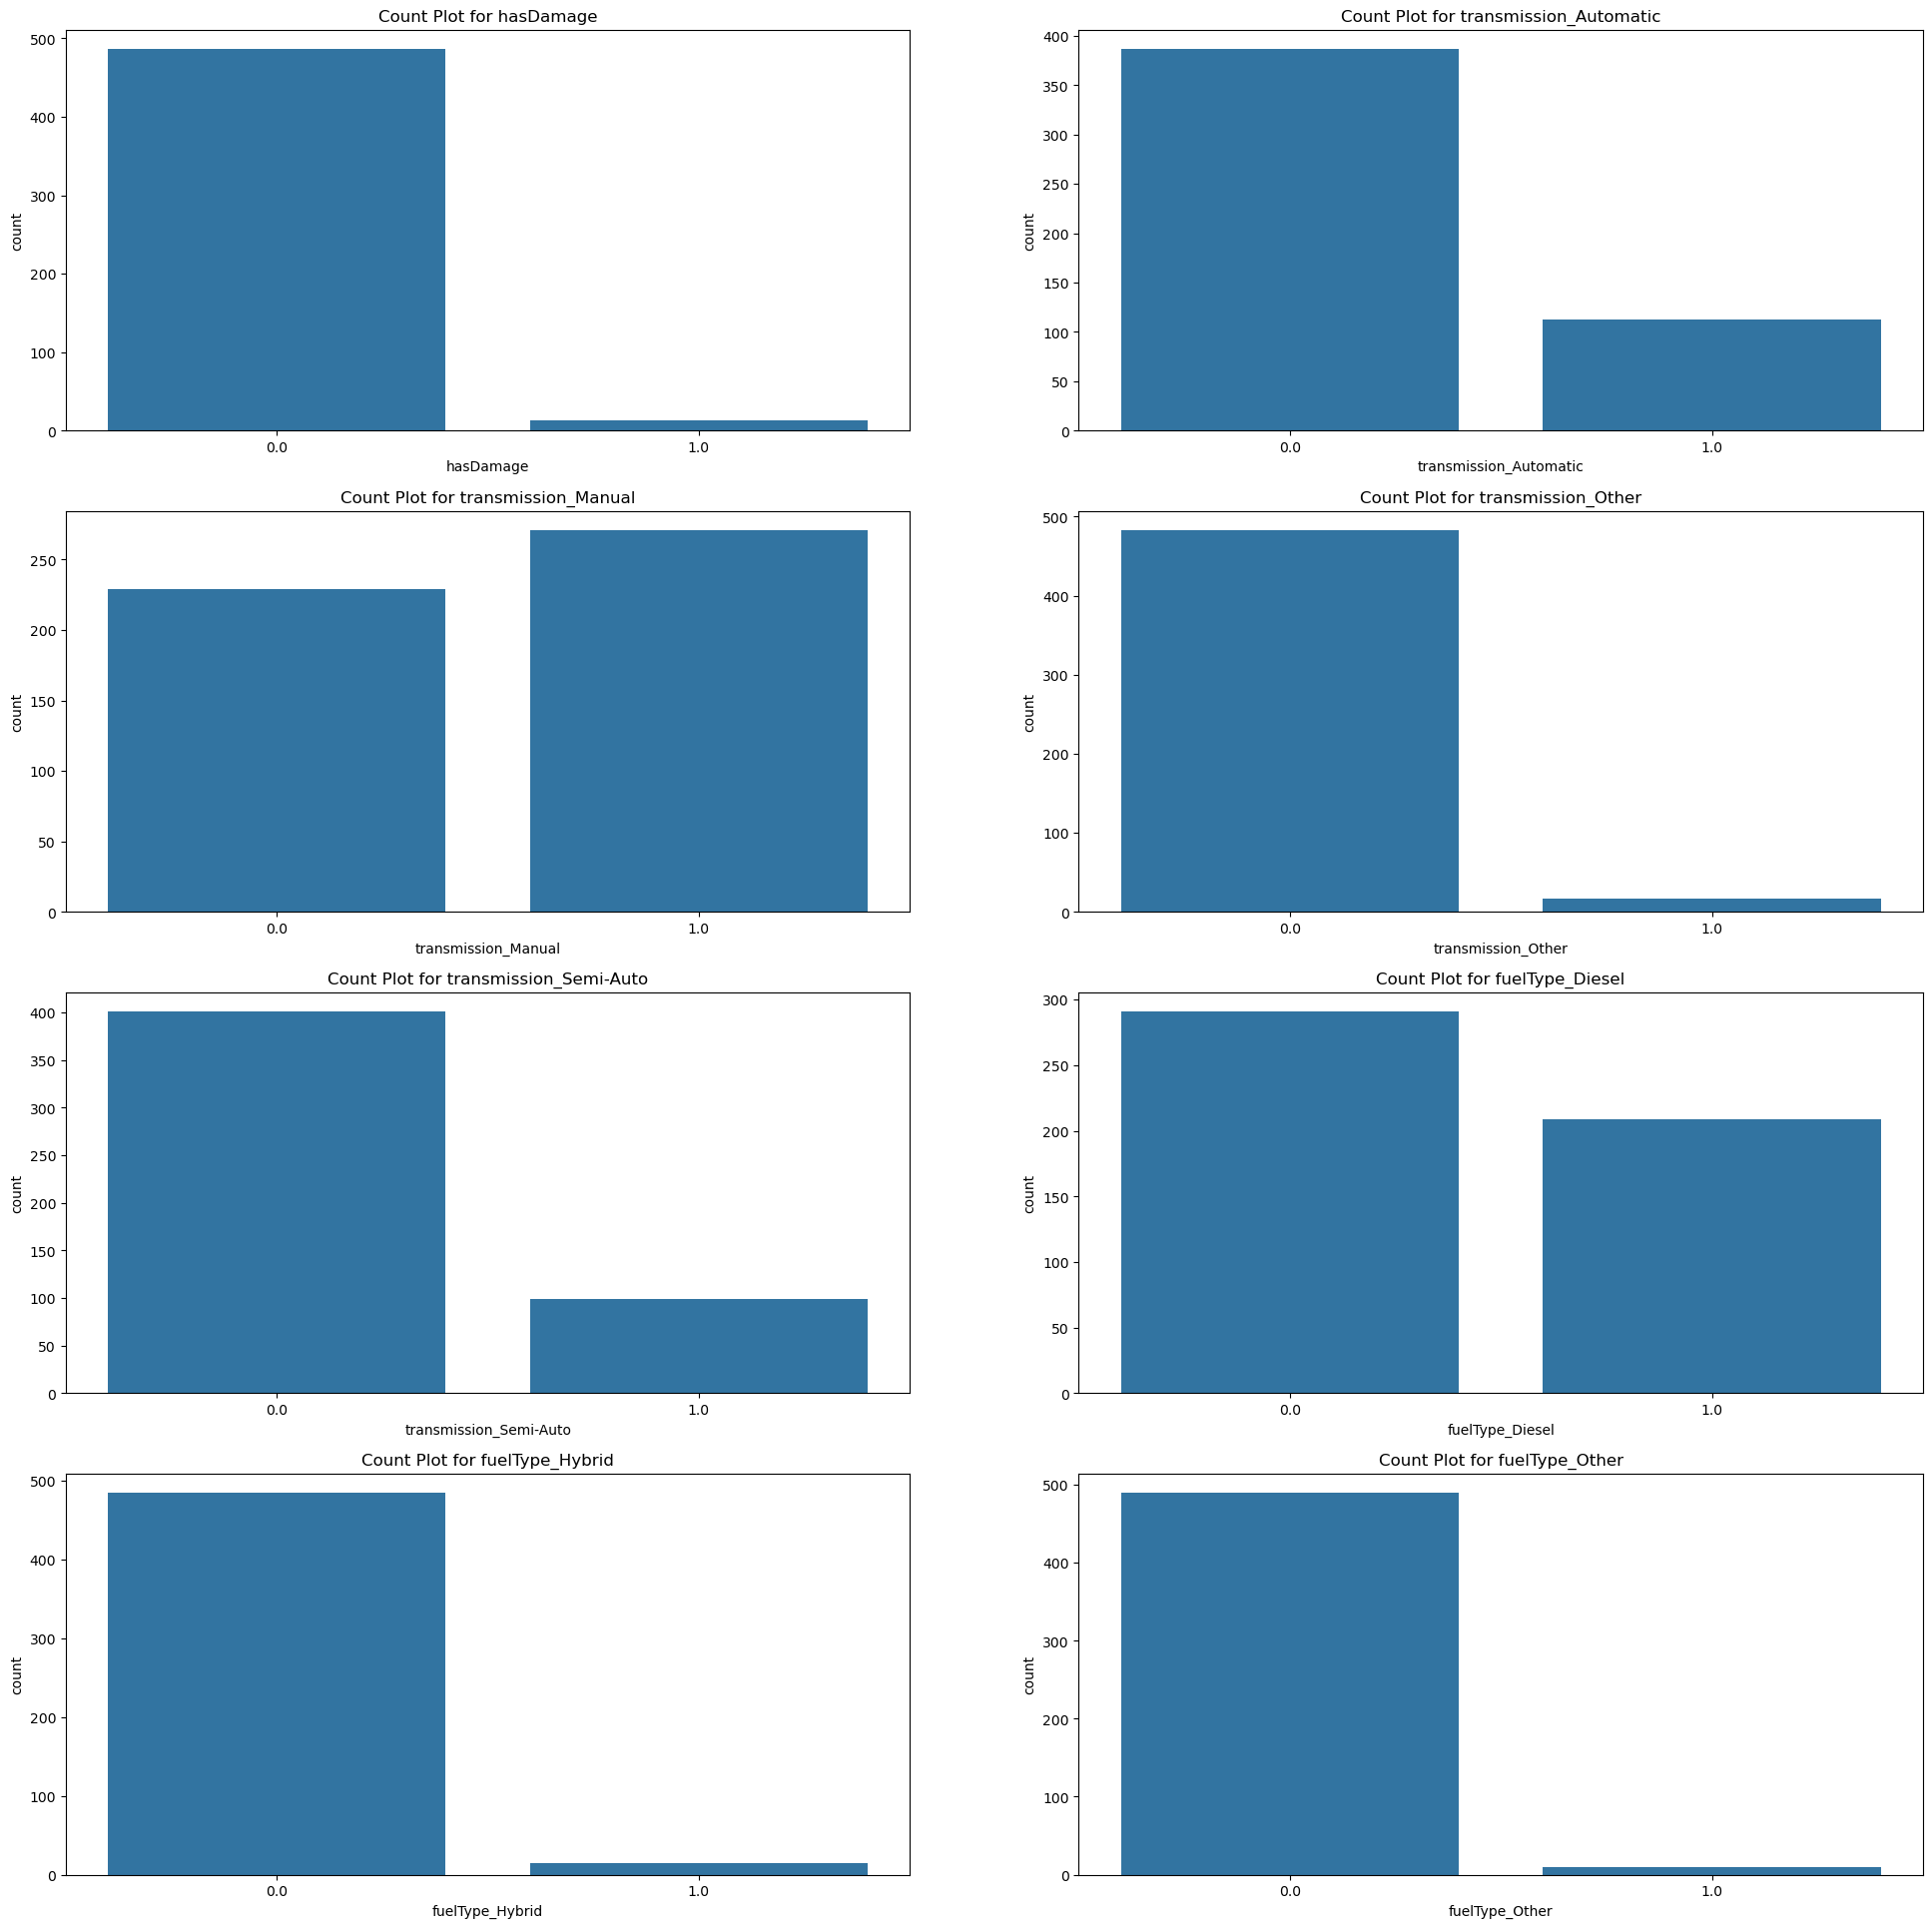

In [13]:
n_features = len(boolean_features)
n_plots_per_row = 2
n_rows = int((n_features) / n_plots_per_row)
fig, axes = plt.subplots(n_rows, n_plots_per_row, figsize=(24, 24))
axes = axes.flatten()
for i, feature in enumerate(boolean_features):
    sns.countplot(x=X_train[feature], ax=axes[i])
    axes[i].set_title(f"Count Plot for {feature}")
    print("-"*50)
    print(f"--- ANALYZING BOOLEAN FEATURE: {feature} ---")
    print("-"*50)
    value_counts = X_train[feature].value_counts()
    print(f"Value counts for {feature}:\n{value_counts}\n")
